In [22]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing as pp
from matplotlib.font_manager import FontProperties

%matplotlib inline
myfont=FontProperties(fname='/usr/share/fonts/truetype/yahei.ttf',size=14)
mpl.rcParams['axes.unicode_minus']=False
sns.set(font=myfont.get_name())

In [23]:
# 数据读取
dateparse = lambda dates: pd.datetime.strptime((str(dates)+'0101')[0:8], '%Y%m%d') if not pd.isnull(dates) else None
company_df = pd.read_csv('/home/phoenixkiller/notebook/bond_data/company_info.csv',
                         parse_dates=['成立日期'],
                         infer_datetime_format = True,
                         date_parser=dateparse)
bond_df = pd.read_csv('/home/phoenixkiller/notebook/bond_data/a.csv',
                      parse_dates=['报告期'],
                      infer_datetime_format = True,
                      date_parser=dateparse)
level_df = pd.read_csv('/home/phoenixkiller/notebook/bond_data/level.csv',
                       parse_dates=['评级日期','公告日期'],
                       infer_datetime_format=True,
                       date_parser=dateparse)
# 标记财务报表类型(年报，半年报，季报)
bond_df['报告类型']=bond_df['报告期'].apply(lambda x: '年报' if x.month==12 else ('半年报' if x.month==6 else '季报'))

# 关联公司基本信息及评级信息
company = pd.merge(company_df, level_df, how='inner', left_on='公司名称', right_on='公司中文名称')

# 去掉不适用的评级
company = company[~company['信用评级'].isin(['A1','A2','A3','Baa1','Ba1','Aa3','B2','Baa3','Ba3','B1'])]

# 删除无用列
company = company.drop(['公司中文简介', '信用评级说明', '法人代表', '总经理', '董事会秘书', '主页', '电子邮箱',
                        '经营范围', '对象ID', '公司ID', '公司中文名称', '主要产品及业务', '办公地址',
                        '评级展望', '债券主体公司id', '前次信用评级', '评级变动方向', '城市'], axis=1)

# 设置列类型
company[['公司类别','评级类型','评级机构代码']] = company[['公司类别','评级类型','评级机构代码']].astype(str)
company['员工总数人'] = company[company['员工总数人'].notnull()]['员工总数人'].astype(int)

# 根据财务报表类型分别关联公司信息及财务报告
bond_year = pd.merge(bond_df[bond_df['报告类型']=='年报'], company, how='inner', on='公司名称')
bond_halfyear = pd.merge(bond_df[bond_df['报告类型']=='半年报'], company, how='inner', on='公司名称')
bond_quarter = pd.merge(bond_df[bond_df['报告类型']=='季报'], company, how='inner', on='公司名称')


In [24]:
def process_data(bond):
    # 删除评级日期<报告期的记录+一个月滞后期(暂时没有实现)
    # 按公司名称，报告期分组排序
    bond['sort_id'] =  bond.loc[bond['报告期']<bond['评级日期'],['评级日期']].groupby([bond['公司名称'], bond['报告期']]).rank(ascending=False)

    fin_columns = ['公司名称','报告期','基本每股收益','每股未分配利润','每股净资产','净资产收益率',
                   '总资产报酬率','总资产净利率（杜邦分析）','经营活动净收益/利润总额','营业外收支净额/利润总额',
                   '销售商品提供劳务收到的现金/营业收入','经营活动产生的现金流量净额/营业收入','资产负债率',
                   '权益乘数(用于杜邦分析) ','流动资产/总资产','归属于母公司的股东权益/全部投入资本','流动比率',
                   '速动比率','产权比率','经营活动产生的现金流量净额/负债合计','存货周转率','应收账款周转率',
                   '总资产周转率','同比增长率-基本每股收益(%)','同比增长率-营业利润(%)',
                   '同比增长率-经营活动产生的现金流量净额(%)']
    # 评级前前期财务指标
    bond_2 = bond.loc[bond['sort_id'] == 2, fin_columns]
    # 评级前前前期财务指标
    bond_3 = bond.loc[bond['sort_id'] == 3, fin_columns]

    # 只保留评级日期和报告期最接近的一条记录
    bond_tmp = bond[bond['sort_id'] == 1]

    # 合并评级日期前两期财务指标
    bond_tmp = pd.merge(bond_tmp, bond_2, how='left', on=['公司名称','报告期'])
    return bond_tmp.drop(['公司代码', '公司名称'], axis=1)

In [25]:
# 数值型字段标准化
def data_normal(bond):
    columns_normal = [
        '基本每股收益',
        '每股未分配利润',
        '每股净资产',
        '净资产收益率',
        '总资产报酬率',
        '总资产净利率（杜邦分析）',
        '经营活动净收益/利润总额',
        '营业外收支净额/利润总额',
        '销售商品提供劳务收到的现金/营业收入',
        '经营活动产生的现金流量净额/营业收入',
        '资产负债率',
        '权益乘数(用于杜邦分析) ',
        '流动资产/总资产',
        '归属于母公司的股东权益/全部投入资本',
        '流动比率',
        '速动比率',
        '产权比率',
        '经营活动产生的现金流量净额/负债合计',
        '存货周转率','应收账款周转率',
        '总资产周转率',
        '同比增长率-基本每股收益(%)',
        '同比增长率-营业利润(%)',
        '同比增长率-经营活动产生的现金流量净额(%)',
        '注册资本万元',
        '员工总数人'
    ]
    for x in columns_normal:
        bond[x] = bond[x].transform(lambda x: (x - x.mean()) / x.std())

In [26]:
def encode_feature(bond):
    bond_tmp = bond.copy()
    # 合并B,C分类, 并取消+/-微调
    bond_tmp['信用评级'] = bond_tmp['信用评级'].apply(lambda x: x[0] if x[0].upper() in ['B', 'C'] else (x[0:-1] if x[-1] in ['+','-'] else x)) 
    # 显示各分类的数量
    sns.factorplot(y='信用评级', data=bond_tmp, kind='count', size=7)
    # 对信用评级进行编码
    le = pp.LabelEncoder()
    le.fit(bond_tmp['信用评级'])
    bond_tmp['信用评级'] = le.transform(bond_tmp['信用评级'])

    # 对类型字段进行onehot编码
    bond_tmp=pd.get_dummies(bond_tmp)

    # bond shuffle
    return bond_tmp.sample(frac=1).reset_index(drop=True), le.classes_


In [27]:
import numpy as np
import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import classification_report
from collections import defaultdict

# 训练模型
def run(data, label, num_round=2000):
    sz = data.shape
    cid = data.shape[1]-1

    train = data.iloc[:int(sz[0] * 0.7), :]
    test = data.iloc[int(sz[0] * 0.7):, :]
    train_X = train.drop(['信用评级','成立日期','评级日期','公告日期','报告期'], axis=1).values
    train_Y = train['信用评级'].values
    test_X = test.drop(['信用评级','成立日期','评级日期','公告日期','报告期'], axis=1).values
    test_Y = test['信用评级'].values

    xg_train = xgb.DMatrix(train_X, label=train_Y)
    xg_test = xgb.DMatrix(test_X, label=test_Y)

    param = {
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',
        'gamma': 0.1,
        'max_depth': 20,
        'lambda': 10,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'colsample_bylevel': 0.7,
        'eta': 0.01,
        'tree_method': 'exact',
        'seed': 0,
        'scale_pos_weight': 5,
        'num_class': 5
    }

    watchlist = [(xg_train,'train'), (xg_test, 'test')]
    bst = xgb.train(param, xg_train, num_round, watchlist )
    # 保存训练模型
    bst.save_model('./bond_data/xgb.model')
    # 计算分类预测准确性
    pred = bst.predict(xg_test)
    # 打印评估结果
    print(classification_report(test_Y, pred, target_names=label))
    
    
    # pred_result = defaultdict(lambda: 0)
    # right_result = defaultdict(lambda: 0)
    # for i in range(len(test_Y)):
    #    pred_result[test_Y[i]] += 1
    #    if int(pred[i]) == test_Y[i]:
    #        right_result[test_Y[i]] += 1
    # print ('predicting, classification error=%f' % (sum( int(pred[i]) != test_Y[i] for i in range(len(test_Y))) / float(len(test_Y))))
    # 统计各分类中，被预测错误的类型分布(未完成)
    # for x in pred_result:
    #    print(label[x], right_result[x]/pred_result[x])


#######################################################################
# do the same thing again, but output probabilities  
#param['objective'] = 'multi:softprob'
#bst = xgb.train(param, xg_train, num_round, watchlist );
# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
#yprob = bst.predict( xg_test ).reshape(test_Y.shape[0], 10)
#ylabel = np.argmax(yprob, axis=1)  # return the index of the biggest pro
#print ('predicting, classification error=%f' % (sum( int(ylabel[i]) != test_Y[i] for i in range(len(test_Y))) / float(len(test_Y)) ))                                                   

In [28]:
# 计算特征权重
def calc_fscore(model_file='./bond_data/xgb.model'):
    import operator
    bst = xgb.Booster()
    bst.load_model(model_file)
    importance = bst.get_fscore('./bond_data/xgb.fmap')
    importance = sorted(importance.items(), key=operator.itemgetter(1))
    df = pd.DataFrame(importance, columns=['feature', 'fscore']).sort_values(by='fscore')
    print(df)

# 保存特征列表
def create_feature_map(features):
    with open('./bond_data/xgb.fmap', 'w', encoding='utf-8') as outfile:
        for i, feat in enumerate(features):
            outfile.write('{0}\t{1}\tq\n'.format(i, feat))

In [29]:
# 测试结果，更多的特征有利于模型准确性提升
# 查看各特征相关性
def show_corr(bond):
    colormap = plt.cm.viridis
    plt.figure(figsize=(15,15))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sns.heatmap(bond.iloc[:,:-1].corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)


In [30]:
# 归一化
data_normal(bond_year)
data_normal(bond_halfyear)
data_normal(bond_quarter)

In [31]:
# 数据关联
b_year = process_data(bond_year)
b_halfyear = process_data(bond_halfyear)
b_quarter = process_data(bond_quarter)

In [32]:
# 查看数值列分布
print(b_year.describe())
# 查看特征数据量
print(b_year.info())

          基本每股收益_x    每股未分配利润_x      每股净资产_x     净资产收益率_x     总资产报酬率_x  \
count  1688.000000  5830.000000  5704.000000  5837.000000  5053.000000   
mean     -0.082349    -0.007114    -0.005256     0.005669     0.033394   
std       0.958642     0.924493     0.908708     1.138212     1.049217   
min      -4.680895    -1.172370    -0.167930   -48.343986    -7.313143   
25%      -0.593346    -0.178649    -0.107809    -0.383092    -0.603252   
50%      -0.265906    -0.139320    -0.092511    -0.159405    -0.224657   
75%       0.207064    -0.052316    -0.048831     0.423332     0.418065   
max      12.085879    41.331841    40.332407    10.191810    13.787911   

       总资产净利率（杜邦分析）_x  经营活动净收益/利润总额_x  营业外收支净额/利润总额_x  销售商品提供劳务收到的现金/营业收入_x  \
count     5734.000000     5606.000000     5573.000000           5022.000000   
mean         0.031590        0.007030       -0.003383              0.000972   
std          1.068844        0.915664        0.882634              1.244310   
min        -10.43

[0]	train-mlogloss:1.59162	test-mlogloss:1.59256
[1]	train-mlogloss:1.57421	test-mlogloss:1.57647
[2]	train-mlogloss:1.55665	test-mlogloss:1.55989
[3]	train-mlogloss:1.53989	test-mlogloss:1.544
[4]	train-mlogloss:1.52394	test-mlogloss:1.52891
[5]	train-mlogloss:1.50792	test-mlogloss:1.51385
[6]	train-mlogloss:1.49174	test-mlogloss:1.49839
[7]	train-mlogloss:1.47606	test-mlogloss:1.48357
[8]	train-mlogloss:1.46114	test-mlogloss:1.46969
[9]	train-mlogloss:1.44599	test-mlogloss:1.45526
[10]	train-mlogloss:1.43141	test-mlogloss:1.44163
[11]	train-mlogloss:1.41661	test-mlogloss:1.42755
[12]	train-mlogloss:1.40273	test-mlogloss:1.4147
[13]	train-mlogloss:1.38903	test-mlogloss:1.4019
[14]	train-mlogloss:1.37547	test-mlogloss:1.38927
[15]	train-mlogloss:1.36206	test-mlogloss:1.3766
[16]	train-mlogloss:1.34865	test-mlogloss:1.36391
[17]	train-mlogloss:1.33545	test-mlogloss:1.35146
[18]	train-mlogloss:1.32241	test-mlogloss:1.33913
[19]	train-mlogloss:1.3097	test-mlogloss:1.32708
[20]	train-mlogl

[160]	train-mlogloss:0.464704	test-mlogloss:0.546691
[161]	train-mlogloss:0.461979	test-mlogloss:0.544241
[162]	train-mlogloss:0.459394	test-mlogloss:0.541944
[163]	train-mlogloss:0.456623	test-mlogloss:0.539442
[164]	train-mlogloss:0.453842	test-mlogloss:0.536878
[165]	train-mlogloss:0.451221	test-mlogloss:0.534629
[166]	train-mlogloss:0.448637	test-mlogloss:0.532412
[167]	train-mlogloss:0.446067	test-mlogloss:0.530179
[168]	train-mlogloss:0.443484	test-mlogloss:0.527826
[169]	train-mlogloss:0.440994	test-mlogloss:0.525626
[170]	train-mlogloss:0.438602	test-mlogloss:0.523527
[171]	train-mlogloss:0.436179	test-mlogloss:0.521326
[172]	train-mlogloss:0.433725	test-mlogloss:0.519219
[173]	train-mlogloss:0.431423	test-mlogloss:0.517256
[174]	train-mlogloss:0.428926	test-mlogloss:0.514963
[175]	train-mlogloss:0.426562	test-mlogloss:0.51283
[176]	train-mlogloss:0.424133	test-mlogloss:0.510641
[177]	train-mlogloss:0.421828	test-mlogloss:0.50867
[178]	train-mlogloss:0.419562	test-mlogloss:0.50

[316]	train-mlogloss:0.217207	test-mlogloss:0.328945
[317]	train-mlogloss:0.216299	test-mlogloss:0.328174
[318]	train-mlogloss:0.215505	test-mlogloss:0.327475
[319]	train-mlogloss:0.214651	test-mlogloss:0.326768
[320]	train-mlogloss:0.213835	test-mlogloss:0.326068
[321]	train-mlogloss:0.213011	test-mlogloss:0.325394
[322]	train-mlogloss:0.212221	test-mlogloss:0.324758
[323]	train-mlogloss:0.211407	test-mlogloss:0.324034
[324]	train-mlogloss:0.210564	test-mlogloss:0.323331
[325]	train-mlogloss:0.209712	test-mlogloss:0.322606
[326]	train-mlogloss:0.208877	test-mlogloss:0.321826
[327]	train-mlogloss:0.208062	test-mlogloss:0.321142
[328]	train-mlogloss:0.207293	test-mlogloss:0.320504
[329]	train-mlogloss:0.206468	test-mlogloss:0.319813
[330]	train-mlogloss:0.205612	test-mlogloss:0.319031
[331]	train-mlogloss:0.20479	test-mlogloss:0.318274
[332]	train-mlogloss:0.204006	test-mlogloss:0.317644
[333]	train-mlogloss:0.203215	test-mlogloss:0.316984
[334]	train-mlogloss:0.202426	test-mlogloss:0.3

[472]	train-mlogloss:0.129348	test-mlogloss:0.255399
[473]	train-mlogloss:0.128981	test-mlogloss:0.255103
[474]	train-mlogloss:0.128625	test-mlogloss:0.254789
[475]	train-mlogloss:0.128302	test-mlogloss:0.254504
[476]	train-mlogloss:0.127938	test-mlogloss:0.254181
[477]	train-mlogloss:0.127583	test-mlogloss:0.253871
[478]	train-mlogloss:0.127234	test-mlogloss:0.253576
[479]	train-mlogloss:0.126889	test-mlogloss:0.253275
[480]	train-mlogloss:0.126567	test-mlogloss:0.253009
[481]	train-mlogloss:0.126255	test-mlogloss:0.252727
[482]	train-mlogloss:0.125902	test-mlogloss:0.252407
[483]	train-mlogloss:0.125582	test-mlogloss:0.252136
[484]	train-mlogloss:0.125244	test-mlogloss:0.251854
[485]	train-mlogloss:0.124884	test-mlogloss:0.251524
[486]	train-mlogloss:0.124547	test-mlogloss:0.251253
[487]	train-mlogloss:0.124213	test-mlogloss:0.25099
[488]	train-mlogloss:0.123861	test-mlogloss:0.250726
[489]	train-mlogloss:0.123557	test-mlogloss:0.250516
[490]	train-mlogloss:0.123242	test-mlogloss:0.2

[628]	train-mlogloss:0.08994	test-mlogloss:0.223368
[629]	train-mlogloss:0.089773	test-mlogloss:0.223247
[630]	train-mlogloss:0.089593	test-mlogloss:0.22313
[631]	train-mlogloss:0.0894	test-mlogloss:0.222945
[632]	train-mlogloss:0.089218	test-mlogloss:0.222774
[633]	train-mlogloss:0.089031	test-mlogloss:0.222627
[634]	train-mlogloss:0.088867	test-mlogloss:0.222464
[635]	train-mlogloss:0.08869	test-mlogloss:0.2223
[636]	train-mlogloss:0.088526	test-mlogloss:0.222161
[637]	train-mlogloss:0.088347	test-mlogloss:0.222013
[638]	train-mlogloss:0.088176	test-mlogloss:0.221854
[639]	train-mlogloss:0.088	test-mlogloss:0.2217
[640]	train-mlogloss:0.087827	test-mlogloss:0.221565
[641]	train-mlogloss:0.087654	test-mlogloss:0.221431
[642]	train-mlogloss:0.087497	test-mlogloss:0.221277
[643]	train-mlogloss:0.087333	test-mlogloss:0.221174
[644]	train-mlogloss:0.08717	test-mlogloss:0.221058
[645]	train-mlogloss:0.087014	test-mlogloss:0.220937
[646]	train-mlogloss:0.086829	test-mlogloss:0.220766
[647]	

[784]	train-mlogloss:0.068439	test-mlogloss:0.206052
[785]	train-mlogloss:0.068348	test-mlogloss:0.205994
[786]	train-mlogloss:0.068261	test-mlogloss:0.205916
[787]	train-mlogloss:0.068151	test-mlogloss:0.205818
[788]	train-mlogloss:0.068042	test-mlogloss:0.205699
[789]	train-mlogloss:0.067946	test-mlogloss:0.20562
[790]	train-mlogloss:0.067847	test-mlogloss:0.20555
[791]	train-mlogloss:0.067733	test-mlogloss:0.205446
[792]	train-mlogloss:0.067629	test-mlogloss:0.20535
[793]	train-mlogloss:0.06754	test-mlogloss:0.205283
[794]	train-mlogloss:0.06743	test-mlogloss:0.205186
[795]	train-mlogloss:0.067317	test-mlogloss:0.205072
[796]	train-mlogloss:0.067216	test-mlogloss:0.204995
[797]	train-mlogloss:0.067114	test-mlogloss:0.204931
[798]	train-mlogloss:0.067013	test-mlogloss:0.204822
[799]	train-mlogloss:0.066916	test-mlogloss:0.204737
[800]	train-mlogloss:0.06682	test-mlogloss:0.204661
[801]	train-mlogloss:0.066721	test-mlogloss:0.204576
[802]	train-mlogloss:0.066625	test-mlogloss:0.204463

[940]	train-mlogloss:0.055355	test-mlogloss:0.195152
[941]	train-mlogloss:0.055282	test-mlogloss:0.195092
[942]	train-mlogloss:0.055206	test-mlogloss:0.195018
[943]	train-mlogloss:0.055136	test-mlogloss:0.194967
[944]	train-mlogloss:0.055055	test-mlogloss:0.194887
[945]	train-mlogloss:0.054986	test-mlogloss:0.194829
[946]	train-mlogloss:0.054918	test-mlogloss:0.19475
[947]	train-mlogloss:0.05486	test-mlogloss:0.19473
[948]	train-mlogloss:0.05479	test-mlogloss:0.194668
[949]	train-mlogloss:0.054717	test-mlogloss:0.194575
[950]	train-mlogloss:0.054653	test-mlogloss:0.194512
[951]	train-mlogloss:0.054585	test-mlogloss:0.194429
[952]	train-mlogloss:0.054521	test-mlogloss:0.194384
[953]	train-mlogloss:0.054457	test-mlogloss:0.194325
[954]	train-mlogloss:0.054392	test-mlogloss:0.194252
[955]	train-mlogloss:0.054326	test-mlogloss:0.194196
[956]	train-mlogloss:0.054258	test-mlogloss:0.194135
[957]	train-mlogloss:0.05419	test-mlogloss:0.194084
[958]	train-mlogloss:0.05412	test-mlogloss:0.194021

[1094]	train-mlogloss:0.046632	test-mlogloss:0.187866
[1095]	train-mlogloss:0.046581	test-mlogloss:0.187847
[1096]	train-mlogloss:0.046528	test-mlogloss:0.187783
[1097]	train-mlogloss:0.046484	test-mlogloss:0.187736
[1098]	train-mlogloss:0.046443	test-mlogloss:0.18768
[1099]	train-mlogloss:0.046394	test-mlogloss:0.187632
[1100]	train-mlogloss:0.046346	test-mlogloss:0.187582
[1101]	train-mlogloss:0.046299	test-mlogloss:0.187552
[1102]	train-mlogloss:0.046255	test-mlogloss:0.187524
[1103]	train-mlogloss:0.046205	test-mlogloss:0.187458
[1104]	train-mlogloss:0.046153	test-mlogloss:0.187413
[1105]	train-mlogloss:0.046109	test-mlogloss:0.187372
[1106]	train-mlogloss:0.046055	test-mlogloss:0.187338
[1107]	train-mlogloss:0.046008	test-mlogloss:0.187306
[1108]	train-mlogloss:0.045958	test-mlogloss:0.18727
[1109]	train-mlogloss:0.045917	test-mlogloss:0.187245
[1110]	train-mlogloss:0.04587	test-mlogloss:0.187209
[1111]	train-mlogloss:0.04583	test-mlogloss:0.187209
[1112]	train-mlogloss:0.045786	t

[1247]	train-mlogloss:0.040522	test-mlogloss:0.182932
[1248]	train-mlogloss:0.040489	test-mlogloss:0.182908
[1249]	train-mlogloss:0.040455	test-mlogloss:0.182908
[1250]	train-mlogloss:0.040426	test-mlogloss:0.182888
[1251]	train-mlogloss:0.040395	test-mlogloss:0.182897
[1252]	train-mlogloss:0.040362	test-mlogloss:0.182862
[1253]	train-mlogloss:0.040327	test-mlogloss:0.182833
[1254]	train-mlogloss:0.040292	test-mlogloss:0.182799
[1255]	train-mlogloss:0.040258	test-mlogloss:0.182777
[1256]	train-mlogloss:0.040232	test-mlogloss:0.182755
[1257]	train-mlogloss:0.0402	test-mlogloss:0.182724
[1258]	train-mlogloss:0.040169	test-mlogloss:0.182693
[1259]	train-mlogloss:0.040137	test-mlogloss:0.182649
[1260]	train-mlogloss:0.040105	test-mlogloss:0.182627
[1261]	train-mlogloss:0.040072	test-mlogloss:0.182589
[1262]	train-mlogloss:0.040045	test-mlogloss:0.182575
[1263]	train-mlogloss:0.040012	test-mlogloss:0.18257
[1264]	train-mlogloss:0.039982	test-mlogloss:0.18254
[1265]	train-mlogloss:0.039948	t

[1400]	train-mlogloss:0.036049	test-mlogloss:0.17968
[1401]	train-mlogloss:0.036021	test-mlogloss:0.179652
[1402]	train-mlogloss:0.035994	test-mlogloss:0.179632
[1403]	train-mlogloss:0.035966	test-mlogloss:0.179601
[1404]	train-mlogloss:0.035941	test-mlogloss:0.179594
[1405]	train-mlogloss:0.03592	test-mlogloss:0.179576
[1406]	train-mlogloss:0.035897	test-mlogloss:0.179572
[1407]	train-mlogloss:0.035874	test-mlogloss:0.179562
[1408]	train-mlogloss:0.035851	test-mlogloss:0.179567
[1409]	train-mlogloss:0.035825	test-mlogloss:0.179531
[1410]	train-mlogloss:0.035805	test-mlogloss:0.179506
[1411]	train-mlogloss:0.035777	test-mlogloss:0.179453
[1412]	train-mlogloss:0.035752	test-mlogloss:0.179431
[1413]	train-mlogloss:0.035725	test-mlogloss:0.179405
[1414]	train-mlogloss:0.035699	test-mlogloss:0.1794
[1415]	train-mlogloss:0.035673	test-mlogloss:0.17938
[1416]	train-mlogloss:0.035647	test-mlogloss:0.17935
[1417]	train-mlogloss:0.035623	test-mlogloss:0.179344
[1418]	train-mlogloss:0.0356	test-

[1553]	train-mlogloss:0.032581	test-mlogloss:0.177059
[1554]	train-mlogloss:0.032561	test-mlogloss:0.177036
[1555]	train-mlogloss:0.032541	test-mlogloss:0.177032
[1556]	train-mlogloss:0.032523	test-mlogloss:0.176995
[1557]	train-mlogloss:0.032506	test-mlogloss:0.176999
[1558]	train-mlogloss:0.032485	test-mlogloss:0.176978
[1559]	train-mlogloss:0.032465	test-mlogloss:0.176954
[1560]	train-mlogloss:0.032447	test-mlogloss:0.176929
[1561]	train-mlogloss:0.032426	test-mlogloss:0.176921
[1562]	train-mlogloss:0.032404	test-mlogloss:0.17691
[1563]	train-mlogloss:0.032383	test-mlogloss:0.176885
[1564]	train-mlogloss:0.032366	test-mlogloss:0.176868
[1565]	train-mlogloss:0.032349	test-mlogloss:0.176854
[1566]	train-mlogloss:0.032334	test-mlogloss:0.176832
[1567]	train-mlogloss:0.032315	test-mlogloss:0.176824
[1568]	train-mlogloss:0.032297	test-mlogloss:0.176821
[1569]	train-mlogloss:0.032276	test-mlogloss:0.176819
[1570]	train-mlogloss:0.032257	test-mlogloss:0.176804
[1571]	train-mlogloss:0.03223

[1706]	train-mlogloss:0.029926	test-mlogloss:0.174991
[1707]	train-mlogloss:0.029912	test-mlogloss:0.174976
[1708]	train-mlogloss:0.029897	test-mlogloss:0.174962
[1709]	train-mlogloss:0.029883	test-mlogloss:0.174966
[1710]	train-mlogloss:0.02987	test-mlogloss:0.17496
[1711]	train-mlogloss:0.029853	test-mlogloss:0.174927
[1712]	train-mlogloss:0.029839	test-mlogloss:0.174899
[1713]	train-mlogloss:0.029823	test-mlogloss:0.174883
[1714]	train-mlogloss:0.029806	test-mlogloss:0.174867
[1715]	train-mlogloss:0.029793	test-mlogloss:0.174867
[1716]	train-mlogloss:0.029777	test-mlogloss:0.174846
[1717]	train-mlogloss:0.029763	test-mlogloss:0.174839
[1718]	train-mlogloss:0.029746	test-mlogloss:0.174828
[1719]	train-mlogloss:0.029731	test-mlogloss:0.174825
[1720]	train-mlogloss:0.029714	test-mlogloss:0.174814
[1721]	train-mlogloss:0.029698	test-mlogloss:0.174827
[1722]	train-mlogloss:0.029683	test-mlogloss:0.17481
[1723]	train-mlogloss:0.02967	test-mlogloss:0.174793
[1724]	train-mlogloss:0.029652	t

[1859]	train-mlogloss:0.027813	test-mlogloss:0.173476
[1860]	train-mlogloss:0.027801	test-mlogloss:0.17346
[1861]	train-mlogloss:0.027788	test-mlogloss:0.173461
[1862]	train-mlogloss:0.027774	test-mlogloss:0.173446
[1863]	train-mlogloss:0.027763	test-mlogloss:0.173448
[1864]	train-mlogloss:0.027753	test-mlogloss:0.173448
[1865]	train-mlogloss:0.027741	test-mlogloss:0.17344
[1866]	train-mlogloss:0.027727	test-mlogloss:0.173436
[1867]	train-mlogloss:0.027711	test-mlogloss:0.173421
[1868]	train-mlogloss:0.027697	test-mlogloss:0.173409
[1869]	train-mlogloss:0.027681	test-mlogloss:0.173381
[1870]	train-mlogloss:0.027668	test-mlogloss:0.173363
[1871]	train-mlogloss:0.027655	test-mlogloss:0.17336
[1872]	train-mlogloss:0.027644	test-mlogloss:0.173352
[1873]	train-mlogloss:0.027633	test-mlogloss:0.173335
[1874]	train-mlogloss:0.027619	test-mlogloss:0.173335
[1875]	train-mlogloss:0.027606	test-mlogloss:0.173317
[1876]	train-mlogloss:0.027592	test-mlogloss:0.173317
[1877]	train-mlogloss:0.02758	t

[2012]	train-mlogloss:0.026082	test-mlogloss:0.172261
[2013]	train-mlogloss:0.026073	test-mlogloss:0.172273
[2014]	train-mlogloss:0.026062	test-mlogloss:0.172271
[2015]	train-mlogloss:0.026054	test-mlogloss:0.172262
[2016]	train-mlogloss:0.026045	test-mlogloss:0.172259
[2017]	train-mlogloss:0.026035	test-mlogloss:0.172239
[2018]	train-mlogloss:0.026027	test-mlogloss:0.172247
[2019]	train-mlogloss:0.026013	test-mlogloss:0.172229
[2020]	train-mlogloss:0.026003	test-mlogloss:0.172229
[2021]	train-mlogloss:0.025993	test-mlogloss:0.172235
[2022]	train-mlogloss:0.025981	test-mlogloss:0.172232
[2023]	train-mlogloss:0.025974	test-mlogloss:0.172206
[2024]	train-mlogloss:0.025964	test-mlogloss:0.172193
[2025]	train-mlogloss:0.025955	test-mlogloss:0.172179
[2026]	train-mlogloss:0.025947	test-mlogloss:0.172178
[2027]	train-mlogloss:0.025938	test-mlogloss:0.172178
[2028]	train-mlogloss:0.025927	test-mlogloss:0.172167
[2029]	train-mlogloss:0.025915	test-mlogloss:0.172169
[2030]	train-mlogloss:0.0259

[2165]	train-mlogloss:0.024687	test-mlogloss:0.171395
[2166]	train-mlogloss:0.024678	test-mlogloss:0.171412
[2167]	train-mlogloss:0.02467	test-mlogloss:0.171426
[2168]	train-mlogloss:0.024663	test-mlogloss:0.171426
[2169]	train-mlogloss:0.024654	test-mlogloss:0.171416
[2170]	train-mlogloss:0.024646	test-mlogloss:0.171408
[2171]	train-mlogloss:0.024638	test-mlogloss:0.171396
[2172]	train-mlogloss:0.024628	test-mlogloss:0.171398
[2173]	train-mlogloss:0.024618	test-mlogloss:0.17139
[2174]	train-mlogloss:0.024605	test-mlogloss:0.171367
[2175]	train-mlogloss:0.024595	test-mlogloss:0.171354
[2176]	train-mlogloss:0.024585	test-mlogloss:0.171339
[2177]	train-mlogloss:0.024577	test-mlogloss:0.171329
[2178]	train-mlogloss:0.024568	test-mlogloss:0.171332
[2179]	train-mlogloss:0.02456	test-mlogloss:0.17133
[2180]	train-mlogloss:0.024552	test-mlogloss:0.17132
[2181]	train-mlogloss:0.024542	test-mlogloss:0.171317
[2182]	train-mlogloss:0.024534	test-mlogloss:0.171309
[2183]	train-mlogloss:0.024525	te

[2318]	train-mlogloss:0.023475	test-mlogloss:0.170575
[2319]	train-mlogloss:0.023467	test-mlogloss:0.170552
[2320]	train-mlogloss:0.02346	test-mlogloss:0.170559
[2321]	train-mlogloss:0.023454	test-mlogloss:0.170552
[2322]	train-mlogloss:0.023448	test-mlogloss:0.170535
[2323]	train-mlogloss:0.023441	test-mlogloss:0.170543
[2324]	train-mlogloss:0.023433	test-mlogloss:0.170526
[2325]	train-mlogloss:0.023425	test-mlogloss:0.170526
[2326]	train-mlogloss:0.023419	test-mlogloss:0.170521
[2327]	train-mlogloss:0.023411	test-mlogloss:0.170516
[2328]	train-mlogloss:0.023403	test-mlogloss:0.170511
[2329]	train-mlogloss:0.023398	test-mlogloss:0.170504
[2330]	train-mlogloss:0.023392	test-mlogloss:0.17051
[2331]	train-mlogloss:0.023385	test-mlogloss:0.170497
[2332]	train-mlogloss:0.023378	test-mlogloss:0.170488
[2333]	train-mlogloss:0.02337	test-mlogloss:0.17047
[2334]	train-mlogloss:0.023361	test-mlogloss:0.170468
[2335]	train-mlogloss:0.023354	test-mlogloss:0.17046
[2336]	train-mlogloss:0.023349	te

[2471]	train-mlogloss:0.022514	test-mlogloss:0.16976
[2472]	train-mlogloss:0.022507	test-mlogloss:0.16974
[2473]	train-mlogloss:0.022502	test-mlogloss:0.169742
[2474]	train-mlogloss:0.022497	test-mlogloss:0.169748
[2475]	train-mlogloss:0.022489	test-mlogloss:0.169739
[2476]	train-mlogloss:0.022483	test-mlogloss:0.169726
[2477]	train-mlogloss:0.022479	test-mlogloss:0.169729
[2478]	train-mlogloss:0.022473	test-mlogloss:0.169725
[2479]	train-mlogloss:0.022468	test-mlogloss:0.169732
[2480]	train-mlogloss:0.022461	test-mlogloss:0.169726
[2481]	train-mlogloss:0.022456	test-mlogloss:0.16973
[2482]	train-mlogloss:0.02245	test-mlogloss:0.16972
[2483]	train-mlogloss:0.022442	test-mlogloss:0.169705
[2484]	train-mlogloss:0.022437	test-mlogloss:0.169711
[2485]	train-mlogloss:0.022433	test-mlogloss:0.169711
[2486]	train-mlogloss:0.022428	test-mlogloss:0.169721
[2487]	train-mlogloss:0.02242	test-mlogloss:0.169714
[2488]	train-mlogloss:0.022416	test-mlogloss:0.169713
[2489]	train-mlogloss:0.022409	tes

[2624]	train-mlogloss:0.021665	test-mlogloss:0.169138
[2625]	train-mlogloss:0.021659	test-mlogloss:0.169146
[2626]	train-mlogloss:0.021655	test-mlogloss:0.169144
[2627]	train-mlogloss:0.021649	test-mlogloss:0.169148
[2628]	train-mlogloss:0.021643	test-mlogloss:0.169152
[2629]	train-mlogloss:0.021639	test-mlogloss:0.169149
[2630]	train-mlogloss:0.021634	test-mlogloss:0.169136
[2631]	train-mlogloss:0.021631	test-mlogloss:0.169134
[2632]	train-mlogloss:0.021624	test-mlogloss:0.16913
[2633]	train-mlogloss:0.021619	test-mlogloss:0.169133
[2634]	train-mlogloss:0.021615	test-mlogloss:0.169119
[2635]	train-mlogloss:0.021611	test-mlogloss:0.169114
[2636]	train-mlogloss:0.021608	test-mlogloss:0.169104
[2637]	train-mlogloss:0.021603	test-mlogloss:0.1691
[2638]	train-mlogloss:0.021599	test-mlogloss:0.169112
[2639]	train-mlogloss:0.021596	test-mlogloss:0.169101
[2640]	train-mlogloss:0.02159	test-mlogloss:0.169095
[2641]	train-mlogloss:0.021585	test-mlogloss:0.169083
[2642]	train-mlogloss:0.02158	te

[2777]	train-mlogloss:0.020967	test-mlogloss:0.16876
[2778]	train-mlogloss:0.020962	test-mlogloss:0.168771
[2779]	train-mlogloss:0.020957	test-mlogloss:0.168761
[2780]	train-mlogloss:0.020953	test-mlogloss:0.168752
[2781]	train-mlogloss:0.020947	test-mlogloss:0.168751
[2782]	train-mlogloss:0.020942	test-mlogloss:0.168735
[2783]	train-mlogloss:0.020938	test-mlogloss:0.168743
[2784]	train-mlogloss:0.020933	test-mlogloss:0.168766
[2785]	train-mlogloss:0.02093	test-mlogloss:0.168759
[2786]	train-mlogloss:0.020927	test-mlogloss:0.16876
[2787]	train-mlogloss:0.020922	test-mlogloss:0.168762
[2788]	train-mlogloss:0.02092	test-mlogloss:0.168765
[2789]	train-mlogloss:0.020916	test-mlogloss:0.168764
[2790]	train-mlogloss:0.020913	test-mlogloss:0.168767
[2791]	train-mlogloss:0.020906	test-mlogloss:0.168764
[2792]	train-mlogloss:0.020902	test-mlogloss:0.16875
[2793]	train-mlogloss:0.020897	test-mlogloss:0.168749
[2794]	train-mlogloss:0.020892	test-mlogloss:0.168745
[2795]	train-mlogloss:0.020889	te

[2930]	train-mlogloss:0.020348	test-mlogloss:0.168352
[2931]	train-mlogloss:0.020343	test-mlogloss:0.168352
[2932]	train-mlogloss:0.020338	test-mlogloss:0.168349
[2933]	train-mlogloss:0.020334	test-mlogloss:0.168347
[2934]	train-mlogloss:0.02033	test-mlogloss:0.168352
[2935]	train-mlogloss:0.020326	test-mlogloss:0.16835
[2936]	train-mlogloss:0.020322	test-mlogloss:0.168354
[2937]	train-mlogloss:0.020318	test-mlogloss:0.168342
[2938]	train-mlogloss:0.020314	test-mlogloss:0.168335
[2939]	train-mlogloss:0.02031	test-mlogloss:0.168318
[2940]	train-mlogloss:0.020306	test-mlogloss:0.168308
[2941]	train-mlogloss:0.020304	test-mlogloss:0.168315
[2942]	train-mlogloss:0.0203	test-mlogloss:0.168316
[2943]	train-mlogloss:0.020296	test-mlogloss:0.168328
[2944]	train-mlogloss:0.020292	test-mlogloss:0.168315
[2945]	train-mlogloss:0.020286	test-mlogloss:0.16831
[2946]	train-mlogloss:0.020282	test-mlogloss:0.168295
[2947]	train-mlogloss:0.020278	test-mlogloss:0.168289
[2948]	train-mlogloss:0.020275	tes

[3083]	train-mlogloss:0.019816	test-mlogloss:0.167925
[3084]	train-mlogloss:0.01981	test-mlogloss:0.167914
[3085]	train-mlogloss:0.019807	test-mlogloss:0.167919
[3086]	train-mlogloss:0.019803	test-mlogloss:0.167918
[3087]	train-mlogloss:0.019797	test-mlogloss:0.167919
[3088]	train-mlogloss:0.019794	test-mlogloss:0.167919
[3089]	train-mlogloss:0.01979	test-mlogloss:0.167922
[3090]	train-mlogloss:0.019787	test-mlogloss:0.16794
[3091]	train-mlogloss:0.019783	test-mlogloss:0.167928
[3092]	train-mlogloss:0.019779	test-mlogloss:0.167933
[3093]	train-mlogloss:0.019777	test-mlogloss:0.167936
[3094]	train-mlogloss:0.019773	test-mlogloss:0.167929
[3095]	train-mlogloss:0.01977	test-mlogloss:0.16792
[3096]	train-mlogloss:0.019766	test-mlogloss:0.167907
[3097]	train-mlogloss:0.019763	test-mlogloss:0.16791
[3098]	train-mlogloss:0.01976	test-mlogloss:0.167909
[3099]	train-mlogloss:0.019758	test-mlogloss:0.167906
[3100]	train-mlogloss:0.019755	test-mlogloss:0.167909
[3101]	train-mlogloss:0.019752	test

[3236]	train-mlogloss:0.01936	test-mlogloss:0.167709
[3237]	train-mlogloss:0.019357	test-mlogloss:0.167717
[3238]	train-mlogloss:0.019355	test-mlogloss:0.167715
[3239]	train-mlogloss:0.019352	test-mlogloss:0.167712
[3240]	train-mlogloss:0.019349	test-mlogloss:0.167715
[3241]	train-mlogloss:0.019347	test-mlogloss:0.167714
[3242]	train-mlogloss:0.019344	test-mlogloss:0.167717
[3243]	train-mlogloss:0.019342	test-mlogloss:0.167722
[3244]	train-mlogloss:0.01934	test-mlogloss:0.167728
[3245]	train-mlogloss:0.019337	test-mlogloss:0.167718
[3246]	train-mlogloss:0.019336	test-mlogloss:0.167715
[3247]	train-mlogloss:0.019332	test-mlogloss:0.167708
[3248]	train-mlogloss:0.019329	test-mlogloss:0.167705
[3249]	train-mlogloss:0.019326	test-mlogloss:0.167697
[3250]	train-mlogloss:0.019324	test-mlogloss:0.167689
[3251]	train-mlogloss:0.019322	test-mlogloss:0.167682
[3252]	train-mlogloss:0.019319	test-mlogloss:0.167684
[3253]	train-mlogloss:0.019314	test-mlogloss:0.167689
[3254]	train-mlogloss:0.019312

[3389]	train-mlogloss:0.018957	test-mlogloss:0.167556
[3390]	train-mlogloss:0.018955	test-mlogloss:0.167572
[3391]	train-mlogloss:0.018952	test-mlogloss:0.167563
[3392]	train-mlogloss:0.018951	test-mlogloss:0.167566
[3393]	train-mlogloss:0.018949	test-mlogloss:0.167564
[3394]	train-mlogloss:0.018947	test-mlogloss:0.167561
[3395]	train-mlogloss:0.018943	test-mlogloss:0.167565
[3396]	train-mlogloss:0.018941	test-mlogloss:0.167558
[3397]	train-mlogloss:0.018938	test-mlogloss:0.167535
[3398]	train-mlogloss:0.018936	test-mlogloss:0.16755
[3399]	train-mlogloss:0.018933	test-mlogloss:0.167552
[3400]	train-mlogloss:0.018928	test-mlogloss:0.167538
[3401]	train-mlogloss:0.018926	test-mlogloss:0.167524
[3402]	train-mlogloss:0.018924	test-mlogloss:0.167524
[3403]	train-mlogloss:0.018923	test-mlogloss:0.167523
[3404]	train-mlogloss:0.01892	test-mlogloss:0.167509
[3405]	train-mlogloss:0.018918	test-mlogloss:0.167519
[3406]	train-mlogloss:0.018916	test-mlogloss:0.167516
[3407]	train-mlogloss:0.018914

[3542]	train-mlogloss:0.018617	test-mlogloss:0.167447
[3543]	train-mlogloss:0.018614	test-mlogloss:0.16744
[3544]	train-mlogloss:0.018613	test-mlogloss:0.167434
[3545]	train-mlogloss:0.018611	test-mlogloss:0.167437
[3546]	train-mlogloss:0.018609	test-mlogloss:0.167446
[3547]	train-mlogloss:0.018608	test-mlogloss:0.167446
[3548]	train-mlogloss:0.018605	test-mlogloss:0.167446
[3549]	train-mlogloss:0.018603	test-mlogloss:0.167437
[3550]	train-mlogloss:0.018601	test-mlogloss:0.167431
[3551]	train-mlogloss:0.018598	test-mlogloss:0.167428
[3552]	train-mlogloss:0.018596	test-mlogloss:0.167417
[3553]	train-mlogloss:0.018594	test-mlogloss:0.167429
[3554]	train-mlogloss:0.018592	test-mlogloss:0.167426
[3555]	train-mlogloss:0.018589	test-mlogloss:0.167425
[3556]	train-mlogloss:0.018586	test-mlogloss:0.167407
[3557]	train-mlogloss:0.018582	test-mlogloss:0.167394
[3558]	train-mlogloss:0.018579	test-mlogloss:0.16739
[3559]	train-mlogloss:0.018577	test-mlogloss:0.167387
[3560]	train-mlogloss:0.018575

[3695]	train-mlogloss:0.018301	test-mlogloss:0.167289
[3696]	train-mlogloss:0.018298	test-mlogloss:0.167297
[3697]	train-mlogloss:0.018296	test-mlogloss:0.167306
[3698]	train-mlogloss:0.018293	test-mlogloss:0.167291
[3699]	train-mlogloss:0.018292	test-mlogloss:0.167294
[3700]	train-mlogloss:0.01829	test-mlogloss:0.167301
[3701]	train-mlogloss:0.018288	test-mlogloss:0.167312
[3702]	train-mlogloss:0.018285	test-mlogloss:0.167304
[3703]	train-mlogloss:0.018284	test-mlogloss:0.167301
[3704]	train-mlogloss:0.018282	test-mlogloss:0.167303
[3705]	train-mlogloss:0.018281	test-mlogloss:0.167302
[3706]	train-mlogloss:0.01828	test-mlogloss:0.167305
[3707]	train-mlogloss:0.018277	test-mlogloss:0.167306
[3708]	train-mlogloss:0.018275	test-mlogloss:0.167304
[3709]	train-mlogloss:0.018273	test-mlogloss:0.16729
[3710]	train-mlogloss:0.018271	test-mlogloss:0.167287
[3711]	train-mlogloss:0.018269	test-mlogloss:0.167285
[3712]	train-mlogloss:0.018268	test-mlogloss:0.167283
[3713]	train-mlogloss:0.018267	

[3848]	train-mlogloss:0.018014	test-mlogloss:0.167293
[3849]	train-mlogloss:0.018014	test-mlogloss:0.167302
[3850]	train-mlogloss:0.018013	test-mlogloss:0.16731
[3851]	train-mlogloss:0.01801	test-mlogloss:0.167307
[3852]	train-mlogloss:0.018009	test-mlogloss:0.167302
[3853]	train-mlogloss:0.018006	test-mlogloss:0.167299
[3854]	train-mlogloss:0.018006	test-mlogloss:0.167305
[3855]	train-mlogloss:0.018004	test-mlogloss:0.167301
[3856]	train-mlogloss:0.018001	test-mlogloss:0.1673
[3857]	train-mlogloss:0.018	test-mlogloss:0.167304
[3858]	train-mlogloss:0.017997	test-mlogloss:0.167306
[3859]	train-mlogloss:0.017996	test-mlogloss:0.167313
[3860]	train-mlogloss:0.017994	test-mlogloss:0.16731
[3861]	train-mlogloss:0.017991	test-mlogloss:0.167314
[3862]	train-mlogloss:0.017988	test-mlogloss:0.16732
[3863]	train-mlogloss:0.017986	test-mlogloss:0.167319
[3864]	train-mlogloss:0.017984	test-mlogloss:0.167324
[3865]	train-mlogloss:0.017983	test-mlogloss:0.16732
[3866]	train-mlogloss:0.017981	test-ml

[4001]	train-mlogloss:0.017754	test-mlogloss:0.167177
[4002]	train-mlogloss:0.017751	test-mlogloss:0.167177
[4003]	train-mlogloss:0.017751	test-mlogloss:0.167175
[4004]	train-mlogloss:0.017748	test-mlogloss:0.167175
[4005]	train-mlogloss:0.017746	test-mlogloss:0.167174
[4006]	train-mlogloss:0.017744	test-mlogloss:0.167175
[4007]	train-mlogloss:0.017743	test-mlogloss:0.16718
[4008]	train-mlogloss:0.017741	test-mlogloss:0.16718
[4009]	train-mlogloss:0.017739	test-mlogloss:0.167182
[4010]	train-mlogloss:0.017737	test-mlogloss:0.167177
[4011]	train-mlogloss:0.017735	test-mlogloss:0.167195
[4012]	train-mlogloss:0.017734	test-mlogloss:0.16719
[4013]	train-mlogloss:0.017733	test-mlogloss:0.167192
[4014]	train-mlogloss:0.017733	test-mlogloss:0.167192
[4015]	train-mlogloss:0.017731	test-mlogloss:0.16718
[4016]	train-mlogloss:0.01773	test-mlogloss:0.167172
[4017]	train-mlogloss:0.017729	test-mlogloss:0.167169
[4018]	train-mlogloss:0.017727	test-mlogloss:0.167174
[4019]	train-mlogloss:0.017727	te

[4154]	train-mlogloss:0.01751	test-mlogloss:0.16703
[4155]	train-mlogloss:0.017509	test-mlogloss:0.167029
[4156]	train-mlogloss:0.017508	test-mlogloss:0.167033
[4157]	train-mlogloss:0.017506	test-mlogloss:0.167031
[4158]	train-mlogloss:0.017506	test-mlogloss:0.167033
[4159]	train-mlogloss:0.017503	test-mlogloss:0.167033
[4160]	train-mlogloss:0.0175	test-mlogloss:0.16702
[4161]	train-mlogloss:0.017499	test-mlogloss:0.167026
[4162]	train-mlogloss:0.017497	test-mlogloss:0.167021
[4163]	train-mlogloss:0.017496	test-mlogloss:0.167021
[4164]	train-mlogloss:0.017495	test-mlogloss:0.167015
[4165]	train-mlogloss:0.017493	test-mlogloss:0.166998
[4166]	train-mlogloss:0.017493	test-mlogloss:0.166997
[4167]	train-mlogloss:0.017492	test-mlogloss:0.166988
[4168]	train-mlogloss:0.017489	test-mlogloss:0.166987
[4169]	train-mlogloss:0.017488	test-mlogloss:0.166991
[4170]	train-mlogloss:0.017485	test-mlogloss:0.166995
[4171]	train-mlogloss:0.017485	test-mlogloss:0.166991
[4172]	train-mlogloss:0.017483	te

[4307]	train-mlogloss:0.017304	test-mlogloss:0.167034
[4308]	train-mlogloss:0.017303	test-mlogloss:0.167028
[4309]	train-mlogloss:0.0173	test-mlogloss:0.167018
[4310]	train-mlogloss:0.017298	test-mlogloss:0.167004
[4311]	train-mlogloss:0.017297	test-mlogloss:0.167006
[4312]	train-mlogloss:0.017297	test-mlogloss:0.167012
[4313]	train-mlogloss:0.017296	test-mlogloss:0.167011
[4314]	train-mlogloss:0.017296	test-mlogloss:0.167011
[4315]	train-mlogloss:0.017295	test-mlogloss:0.167009
[4316]	train-mlogloss:0.017294	test-mlogloss:0.167017
[4317]	train-mlogloss:0.017294	test-mlogloss:0.167017
[4318]	train-mlogloss:0.017293	test-mlogloss:0.167007
[4319]	train-mlogloss:0.017292	test-mlogloss:0.167008
[4320]	train-mlogloss:0.017291	test-mlogloss:0.167013
[4321]	train-mlogloss:0.017291	test-mlogloss:0.167012
[4322]	train-mlogloss:0.017289	test-mlogloss:0.167012
[4323]	train-mlogloss:0.017288	test-mlogloss:0.167013
[4324]	train-mlogloss:0.017287	test-mlogloss:0.16701
[4325]	train-mlogloss:0.017285	

[4460]	train-mlogloss:0.017114	test-mlogloss:0.166951
[4461]	train-mlogloss:0.017112	test-mlogloss:0.166949
[4462]	train-mlogloss:0.017111	test-mlogloss:0.166952
[4463]	train-mlogloss:0.01711	test-mlogloss:0.166958
[4464]	train-mlogloss:0.017108	test-mlogloss:0.166958
[4465]	train-mlogloss:0.017107	test-mlogloss:0.166961
[4466]	train-mlogloss:0.017106	test-mlogloss:0.16697
[4467]	train-mlogloss:0.017105	test-mlogloss:0.166969
[4468]	train-mlogloss:0.017104	test-mlogloss:0.166977
[4469]	train-mlogloss:0.017103	test-mlogloss:0.166977
[4470]	train-mlogloss:0.017102	test-mlogloss:0.166972
[4471]	train-mlogloss:0.0171	test-mlogloss:0.166974
[4472]	train-mlogloss:0.017099	test-mlogloss:0.166969
[4473]	train-mlogloss:0.017097	test-mlogloss:0.166964
[4474]	train-mlogloss:0.017097	test-mlogloss:0.166965
[4475]	train-mlogloss:0.017096	test-mlogloss:0.166975
[4476]	train-mlogloss:0.017095	test-mlogloss:0.16698
[4477]	train-mlogloss:0.017093	test-mlogloss:0.16698
[4478]	train-mlogloss:0.017093	tes

[4613]	train-mlogloss:0.016938	test-mlogloss:0.166881
[4614]	train-mlogloss:0.016936	test-mlogloss:0.166878
[4615]	train-mlogloss:0.016936	test-mlogloss:0.166881
[4616]	train-mlogloss:0.016935	test-mlogloss:0.166881
[4617]	train-mlogloss:0.016934	test-mlogloss:0.16688
[4618]	train-mlogloss:0.016933	test-mlogloss:0.166873
[4619]	train-mlogloss:0.016932	test-mlogloss:0.166874
[4620]	train-mlogloss:0.01693	test-mlogloss:0.166867
[4621]	train-mlogloss:0.01693	test-mlogloss:0.166867
[4622]	train-mlogloss:0.016929	test-mlogloss:0.166866
[4623]	train-mlogloss:0.016927	test-mlogloss:0.166861
[4624]	train-mlogloss:0.016927	test-mlogloss:0.166863
[4625]	train-mlogloss:0.016926	test-mlogloss:0.166861
[4626]	train-mlogloss:0.016926	test-mlogloss:0.166869
[4627]	train-mlogloss:0.016924	test-mlogloss:0.166869
[4628]	train-mlogloss:0.016923	test-mlogloss:0.166861
[4629]	train-mlogloss:0.016923	test-mlogloss:0.166862
[4630]	train-mlogloss:0.016923	test-mlogloss:0.166862
[4631]	train-mlogloss:0.016922	

[4766]	train-mlogloss:0.016773	test-mlogloss:0.166848
[4767]	train-mlogloss:0.016772	test-mlogloss:0.16685
[4768]	train-mlogloss:0.016772	test-mlogloss:0.166846
[4769]	train-mlogloss:0.016772	test-mlogloss:0.166842
[4770]	train-mlogloss:0.016771	test-mlogloss:0.166841
[4771]	train-mlogloss:0.01677	test-mlogloss:0.166841
[4772]	train-mlogloss:0.016768	test-mlogloss:0.16684
[4773]	train-mlogloss:0.016768	test-mlogloss:0.166846
[4774]	train-mlogloss:0.016766	test-mlogloss:0.166839
[4775]	train-mlogloss:0.016766	test-mlogloss:0.166834
[4776]	train-mlogloss:0.016765	test-mlogloss:0.166832
[4777]	train-mlogloss:0.016764	test-mlogloss:0.166827
[4778]	train-mlogloss:0.016762	test-mlogloss:0.166829
[4779]	train-mlogloss:0.016762	test-mlogloss:0.166824
[4780]	train-mlogloss:0.016761	test-mlogloss:0.166834
[4781]	train-mlogloss:0.01676	test-mlogloss:0.166831
[4782]	train-mlogloss:0.016759	test-mlogloss:0.16683
[4783]	train-mlogloss:0.016759	test-mlogloss:0.166832
[4784]	train-mlogloss:0.016759	te

[4919]	train-mlogloss:0.016625	test-mlogloss:0.166781
[4920]	train-mlogloss:0.016623	test-mlogloss:0.166774
[4921]	train-mlogloss:0.016623	test-mlogloss:0.166776
[4922]	train-mlogloss:0.016622	test-mlogloss:0.16678
[4923]	train-mlogloss:0.016621	test-mlogloss:0.166778
[4924]	train-mlogloss:0.016621	test-mlogloss:0.166776
[4925]	train-mlogloss:0.01662	test-mlogloss:0.166775
[4926]	train-mlogloss:0.01662	test-mlogloss:0.166771
[4927]	train-mlogloss:0.016618	test-mlogloss:0.166768
[4928]	train-mlogloss:0.016617	test-mlogloss:0.166763
[4929]	train-mlogloss:0.016616	test-mlogloss:0.166767
[4930]	train-mlogloss:0.016615	test-mlogloss:0.166765
[4931]	train-mlogloss:0.016614	test-mlogloss:0.166769
[4932]	train-mlogloss:0.016614	test-mlogloss:0.166758
[4933]	train-mlogloss:0.016614	test-mlogloss:0.166758
[4934]	train-mlogloss:0.016613	test-mlogloss:0.166754
[4935]	train-mlogloss:0.016613	test-mlogloss:0.166753
[4936]	train-mlogloss:0.016611	test-mlogloss:0.166754
[4937]	train-mlogloss:0.01661	t

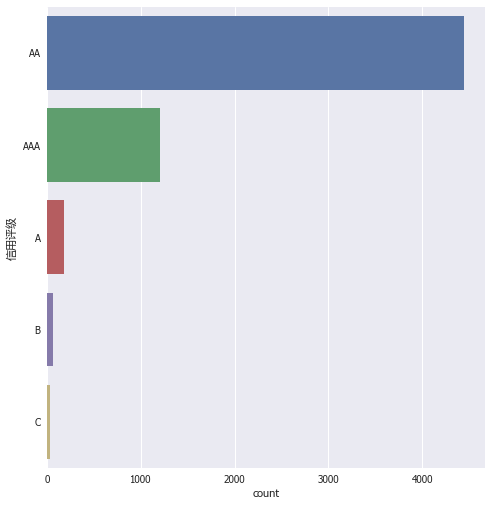

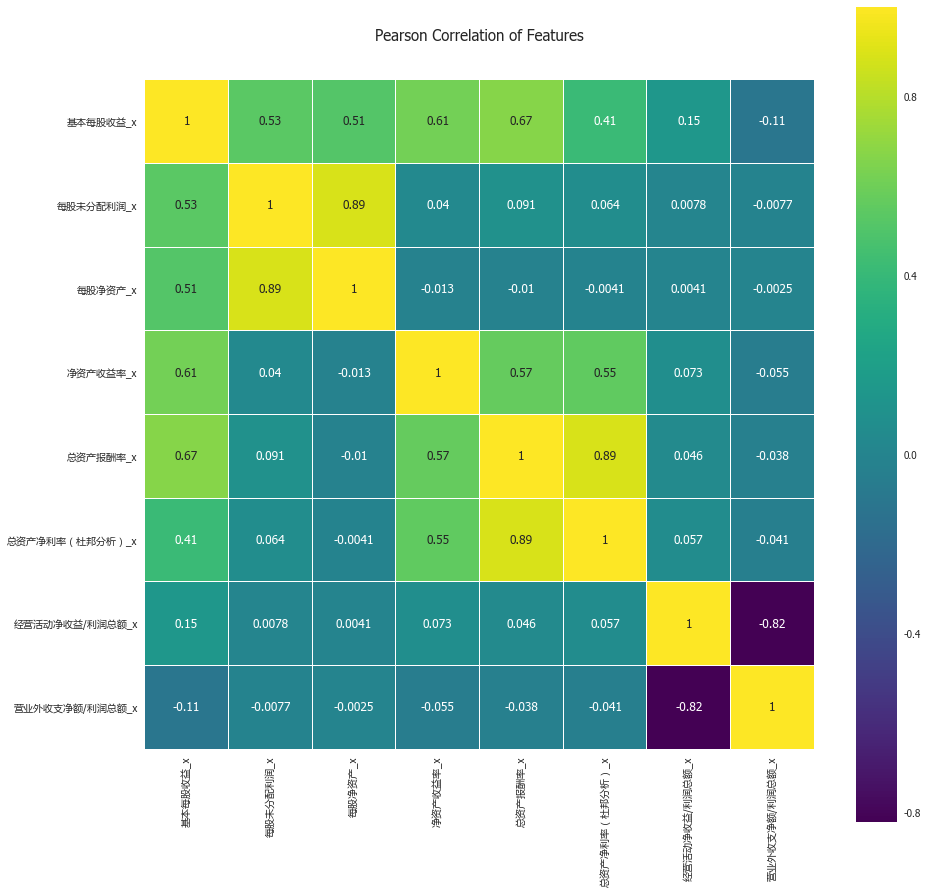

In [33]:
# 是否存在同一公司的多条记录？
# 是否省份，地市会提高准确率？
b, label = encode_feature(b_year)
show_corr(b.iloc[:,:10])
run(b, label, 5000)
create_feature_map(b.columns)
# calc_fscore()

[0]	train-mlogloss:1.59164	test-mlogloss:1.59209
[1]	train-mlogloss:1.57408	test-mlogloss:1.57504
[2]	train-mlogloss:1.55679	test-mlogloss:1.55835
[3]	train-mlogloss:1.54017	test-mlogloss:1.54248
[4]	train-mlogloss:1.524	test-mlogloss:1.527
[5]	train-mlogloss:1.50828	test-mlogloss:1.51199
[6]	train-mlogloss:1.49283	test-mlogloss:1.49715
[7]	train-mlogloss:1.47731	test-mlogloss:1.48222
[8]	train-mlogloss:1.46193	test-mlogloss:1.46759
[9]	train-mlogloss:1.44686	test-mlogloss:1.45307
[10]	train-mlogloss:1.43209	test-mlogloss:1.43903
[11]	train-mlogloss:1.41793	test-mlogloss:1.42535
[12]	train-mlogloss:1.40361	test-mlogloss:1.41186
[13]	train-mlogloss:1.38987	test-mlogloss:1.39877
[14]	train-mlogloss:1.37601	test-mlogloss:1.38559
[15]	train-mlogloss:1.36232	test-mlogloss:1.37242
[16]	train-mlogloss:1.3498	test-mlogloss:1.36073
[17]	train-mlogloss:1.33671	test-mlogloss:1.34834
[18]	train-mlogloss:1.3242	test-mlogloss:1.33649
[19]	train-mlogloss:1.31179	test-mlogloss:1.32458
[20]	train-mlogl

[160]	train-mlogloss:0.474359	test-mlogloss:0.544939
[161]	train-mlogloss:0.471639	test-mlogloss:0.542482
[162]	train-mlogloss:0.468948	test-mlogloss:0.540136
[163]	train-mlogloss:0.466306	test-mlogloss:0.537796
[164]	train-mlogloss:0.463615	test-mlogloss:0.535399
[165]	train-mlogloss:0.461049	test-mlogloss:0.533108
[166]	train-mlogloss:0.458414	test-mlogloss:0.530799
[167]	train-mlogloss:0.455775	test-mlogloss:0.528443
[168]	train-mlogloss:0.453236	test-mlogloss:0.526173
[169]	train-mlogloss:0.450588	test-mlogloss:0.523728
[170]	train-mlogloss:0.448069	test-mlogloss:0.521432
[171]	train-mlogloss:0.445535	test-mlogloss:0.519205
[172]	train-mlogloss:0.442944	test-mlogloss:0.516855
[173]	train-mlogloss:0.440439	test-mlogloss:0.51461
[174]	train-mlogloss:0.437921	test-mlogloss:0.512361
[175]	train-mlogloss:0.435499	test-mlogloss:0.510252
[176]	train-mlogloss:0.43311	test-mlogloss:0.508179
[177]	train-mlogloss:0.430666	test-mlogloss:0.506016
[178]	train-mlogloss:0.428239	test-mlogloss:0.50

[316]	train-mlogloss:0.226325	test-mlogloss:0.333164
[317]	train-mlogloss:0.225474	test-mlogloss:0.332475
[318]	train-mlogloss:0.224583	test-mlogloss:0.33175
[319]	train-mlogloss:0.223714	test-mlogloss:0.331098
[320]	train-mlogloss:0.222836	test-mlogloss:0.330371
[321]	train-mlogloss:0.22205	test-mlogloss:0.329776
[322]	train-mlogloss:0.221174	test-mlogloss:0.329089
[323]	train-mlogloss:0.220349	test-mlogloss:0.328394
[324]	train-mlogloss:0.2195	test-mlogloss:0.327718
[325]	train-mlogloss:0.218677	test-mlogloss:0.327091
[326]	train-mlogloss:0.217826	test-mlogloss:0.326411
[327]	train-mlogloss:0.217046	test-mlogloss:0.325834
[328]	train-mlogloss:0.216233	test-mlogloss:0.32518
[329]	train-mlogloss:0.215463	test-mlogloss:0.324616
[330]	train-mlogloss:0.214687	test-mlogloss:0.324009
[331]	train-mlogloss:0.213886	test-mlogloss:0.323392
[332]	train-mlogloss:0.213087	test-mlogloss:0.322773
[333]	train-mlogloss:0.212311	test-mlogloss:0.322165
[334]	train-mlogloss:0.211515	test-mlogloss:0.32154

[472]	train-mlogloss:0.1367	test-mlogloss:0.265573
[473]	train-mlogloss:0.136318	test-mlogloss:0.265264
[474]	train-mlogloss:0.135966	test-mlogloss:0.265036
[475]	train-mlogloss:0.135606	test-mlogloss:0.264801
[476]	train-mlogloss:0.135259	test-mlogloss:0.264545
[477]	train-mlogloss:0.134871	test-mlogloss:0.264288
[478]	train-mlogloss:0.134493	test-mlogloss:0.263996
[479]	train-mlogloss:0.134146	test-mlogloss:0.26376
[480]	train-mlogloss:0.133815	test-mlogloss:0.26355
[481]	train-mlogloss:0.133469	test-mlogloss:0.263329
[482]	train-mlogloss:0.133123	test-mlogloss:0.263126
[483]	train-mlogloss:0.132767	test-mlogloss:0.262854
[484]	train-mlogloss:0.13242	test-mlogloss:0.262586
[485]	train-mlogloss:0.132074	test-mlogloss:0.262355
[486]	train-mlogloss:0.131729	test-mlogloss:0.262112
[487]	train-mlogloss:0.131389	test-mlogloss:0.261905
[488]	train-mlogloss:0.131061	test-mlogloss:0.261724
[489]	train-mlogloss:0.130704	test-mlogloss:0.261479
[490]	train-mlogloss:0.130353	test-mlogloss:0.26129

[628]	train-mlogloss:0.095643	test-mlogloss:0.238504
[629]	train-mlogloss:0.095438	test-mlogloss:0.238365
[630]	train-mlogloss:0.095251	test-mlogloss:0.238247
[631]	train-mlogloss:0.095052	test-mlogloss:0.238123
[632]	train-mlogloss:0.094881	test-mlogloss:0.238048
[633]	train-mlogloss:0.094675	test-mlogloss:0.237926
[634]	train-mlogloss:0.094474	test-mlogloss:0.237783
[635]	train-mlogloss:0.094285	test-mlogloss:0.237686
[636]	train-mlogloss:0.094102	test-mlogloss:0.237599
[637]	train-mlogloss:0.093909	test-mlogloss:0.23745
[638]	train-mlogloss:0.093715	test-mlogloss:0.23731
[639]	train-mlogloss:0.093554	test-mlogloss:0.237265
[640]	train-mlogloss:0.093381	test-mlogloss:0.237169
[641]	train-mlogloss:0.09321	test-mlogloss:0.237092
[642]	train-mlogloss:0.09305	test-mlogloss:0.236972
[643]	train-mlogloss:0.09287	test-mlogloss:0.236836
[644]	train-mlogloss:0.092692	test-mlogloss:0.236731
[645]	train-mlogloss:0.092505	test-mlogloss:0.236633
[646]	train-mlogloss:0.092343	test-mlogloss:0.23655

[784]	train-mlogloss:0.072868	test-mlogloss:0.225089
[785]	train-mlogloss:0.072749	test-mlogloss:0.22499
[786]	train-mlogloss:0.072633	test-mlogloss:0.224876
[787]	train-mlogloss:0.072528	test-mlogloss:0.224813
[788]	train-mlogloss:0.072418	test-mlogloss:0.22478
[789]	train-mlogloss:0.072308	test-mlogloss:0.224704
[790]	train-mlogloss:0.072198	test-mlogloss:0.224637
[791]	train-mlogloss:0.0721	test-mlogloss:0.22457
[792]	train-mlogloss:0.071998	test-mlogloss:0.224527
[793]	train-mlogloss:0.071885	test-mlogloss:0.224477
[794]	train-mlogloss:0.071768	test-mlogloss:0.224422
[795]	train-mlogloss:0.071655	test-mlogloss:0.224342
[796]	train-mlogloss:0.071543	test-mlogloss:0.224273
[797]	train-mlogloss:0.071439	test-mlogloss:0.22423
[798]	train-mlogloss:0.071335	test-mlogloss:0.224166
[799]	train-mlogloss:0.071226	test-mlogloss:0.224113
[800]	train-mlogloss:0.071114	test-mlogloss:0.224055
[801]	train-mlogloss:0.071005	test-mlogloss:0.223993
[802]	train-mlogloss:0.070892	test-mlogloss:0.223912

[940]	train-mlogloss:0.058721	test-mlogloss:0.217108
[941]	train-mlogloss:0.058651	test-mlogloss:0.217072
[942]	train-mlogloss:0.058572	test-mlogloss:0.217013
[943]	train-mlogloss:0.058504	test-mlogloss:0.216984
[944]	train-mlogloss:0.05843	test-mlogloss:0.21695
[945]	train-mlogloss:0.058363	test-mlogloss:0.216881
[946]	train-mlogloss:0.058292	test-mlogloss:0.21682
[947]	train-mlogloss:0.058217	test-mlogloss:0.216748
[948]	train-mlogloss:0.058151	test-mlogloss:0.216708
[949]	train-mlogloss:0.05808	test-mlogloss:0.216671
[950]	train-mlogloss:0.058007	test-mlogloss:0.216622
[951]	train-mlogloss:0.057942	test-mlogloss:0.21657
[952]	train-mlogloss:0.057884	test-mlogloss:0.216553
[953]	train-mlogloss:0.057816	test-mlogloss:0.216518
[954]	train-mlogloss:0.057747	test-mlogloss:0.216494
[955]	train-mlogloss:0.05768	test-mlogloss:0.216439
[956]	train-mlogloss:0.057609	test-mlogloss:0.216409
[957]	train-mlogloss:0.057539	test-mlogloss:0.216377
[958]	train-mlogloss:0.057471	test-mlogloss:0.216344

[1094]	train-mlogloss:0.049404	test-mlogloss:0.212391
[1095]	train-mlogloss:0.049354	test-mlogloss:0.212384
[1096]	train-mlogloss:0.049307	test-mlogloss:0.212377
[1097]	train-mlogloss:0.04926	test-mlogloss:0.212354
[1098]	train-mlogloss:0.049208	test-mlogloss:0.212314
[1099]	train-mlogloss:0.049158	test-mlogloss:0.212281
[1100]	train-mlogloss:0.049106	test-mlogloss:0.212254
[1101]	train-mlogloss:0.049056	test-mlogloss:0.212211
[1102]	train-mlogloss:0.049008	test-mlogloss:0.212208
[1103]	train-mlogloss:0.048968	test-mlogloss:0.212204
[1104]	train-mlogloss:0.048918	test-mlogloss:0.21217
[1105]	train-mlogloss:0.048866	test-mlogloss:0.212141
[1106]	train-mlogloss:0.048815	test-mlogloss:0.212099
[1107]	train-mlogloss:0.048769	test-mlogloss:0.212077
[1108]	train-mlogloss:0.048721	test-mlogloss:0.212052
[1109]	train-mlogloss:0.048676	test-mlogloss:0.212024
[1110]	train-mlogloss:0.048623	test-mlogloss:0.21199
[1111]	train-mlogloss:0.04857	test-mlogloss:0.211968
[1112]	train-mlogloss:0.048523	t

[1247]	train-mlogloss:0.042844	test-mlogloss:0.208801
[1248]	train-mlogloss:0.042804	test-mlogloss:0.20877
[1249]	train-mlogloss:0.042768	test-mlogloss:0.208744
[1250]	train-mlogloss:0.04273	test-mlogloss:0.208722
[1251]	train-mlogloss:0.042698	test-mlogloss:0.208702
[1252]	train-mlogloss:0.042664	test-mlogloss:0.208684
[1253]	train-mlogloss:0.042624	test-mlogloss:0.208669
[1254]	train-mlogloss:0.042586	test-mlogloss:0.208669
[1255]	train-mlogloss:0.042556	test-mlogloss:0.208656
[1256]	train-mlogloss:0.042526	test-mlogloss:0.208647
[1257]	train-mlogloss:0.042485	test-mlogloss:0.20861
[1258]	train-mlogloss:0.042446	test-mlogloss:0.208588
[1259]	train-mlogloss:0.042413	test-mlogloss:0.20856
[1260]	train-mlogloss:0.042373	test-mlogloss:0.208558
[1261]	train-mlogloss:0.042344	test-mlogloss:0.20856
[1262]	train-mlogloss:0.042308	test-mlogloss:0.208535
[1263]	train-mlogloss:0.04227	test-mlogloss:0.208524
[1264]	train-mlogloss:0.042235	test-mlogloss:0.208497
[1265]	train-mlogloss:0.042198	tes

[1400]	train-mlogloss:0.038003	test-mlogloss:0.206451
[1401]	train-mlogloss:0.037977	test-mlogloss:0.206437
[1402]	train-mlogloss:0.037951	test-mlogloss:0.206437
[1403]	train-mlogloss:0.037924	test-mlogloss:0.206415
[1404]	train-mlogloss:0.037893	test-mlogloss:0.206398
[1405]	train-mlogloss:0.037868	test-mlogloss:0.206384
[1406]	train-mlogloss:0.03784	test-mlogloss:0.206372
[1407]	train-mlogloss:0.037812	test-mlogloss:0.206346
[1408]	train-mlogloss:0.037788	test-mlogloss:0.206323
[1409]	train-mlogloss:0.03776	test-mlogloss:0.206303
[1410]	train-mlogloss:0.037733	test-mlogloss:0.206286
[1411]	train-mlogloss:0.037708	test-mlogloss:0.206275
[1412]	train-mlogloss:0.037678	test-mlogloss:0.206261
[1413]	train-mlogloss:0.037653	test-mlogloss:0.206266
[1414]	train-mlogloss:0.037629	test-mlogloss:0.206246
[1415]	train-mlogloss:0.037605	test-mlogloss:0.206251
[1416]	train-mlogloss:0.037581	test-mlogloss:0.206241
[1417]	train-mlogloss:0.037553	test-mlogloss:0.206232
[1418]	train-mlogloss:0.037524

[1553]	train-mlogloss:0.034363	test-mlogloss:0.20479
[1554]	train-mlogloss:0.034342	test-mlogloss:0.204792
[1555]	train-mlogloss:0.034321	test-mlogloss:0.204788
[1556]	train-mlogloss:0.034295	test-mlogloss:0.204767
[1557]	train-mlogloss:0.034273	test-mlogloss:0.204735
[1558]	train-mlogloss:0.034251	test-mlogloss:0.204723
[1559]	train-mlogloss:0.034229	test-mlogloss:0.204716
[1560]	train-mlogloss:0.034209	test-mlogloss:0.204735
[1561]	train-mlogloss:0.03419	test-mlogloss:0.204732
[1562]	train-mlogloss:0.034172	test-mlogloss:0.204733
[1563]	train-mlogloss:0.034156	test-mlogloss:0.204743
[1564]	train-mlogloss:0.034134	test-mlogloss:0.204722
[1565]	train-mlogloss:0.034115	test-mlogloss:0.204707
[1566]	train-mlogloss:0.034092	test-mlogloss:0.204721
[1567]	train-mlogloss:0.03407	test-mlogloss:0.204711
[1568]	train-mlogloss:0.034051	test-mlogloss:0.204683
[1569]	train-mlogloss:0.034029	test-mlogloss:0.204669
[1570]	train-mlogloss:0.034009	test-mlogloss:0.204656
[1571]	train-mlogloss:0.033989	

[1706]	train-mlogloss:0.031528	test-mlogloss:0.203847
[1707]	train-mlogloss:0.031512	test-mlogloss:0.203837
[1708]	train-mlogloss:0.031494	test-mlogloss:0.203828
[1709]	train-mlogloss:0.031479	test-mlogloss:0.203829
[1710]	train-mlogloss:0.031462	test-mlogloss:0.203831
[1711]	train-mlogloss:0.031451	test-mlogloss:0.203824
[1712]	train-mlogloss:0.031434	test-mlogloss:0.203812
[1713]	train-mlogloss:0.031417	test-mlogloss:0.203812
[1714]	train-mlogloss:0.031398	test-mlogloss:0.203813
[1715]	train-mlogloss:0.031384	test-mlogloss:0.203813
[1716]	train-mlogloss:0.031367	test-mlogloss:0.203812
[1717]	train-mlogloss:0.031351	test-mlogloss:0.203815
[1718]	train-mlogloss:0.031335	test-mlogloss:0.203821
[1719]	train-mlogloss:0.031319	test-mlogloss:0.203823
[1720]	train-mlogloss:0.031302	test-mlogloss:0.203825
[1721]	train-mlogloss:0.031287	test-mlogloss:0.203832
[1722]	train-mlogloss:0.031269	test-mlogloss:0.203818
[1723]	train-mlogloss:0.031253	test-mlogloss:0.203804
[1724]	train-mlogloss:0.0312

[1859]	train-mlogloss:0.02926	test-mlogloss:0.203038
[1860]	train-mlogloss:0.029247	test-mlogloss:0.203032
[1861]	train-mlogloss:0.029235	test-mlogloss:0.203023
[1862]	train-mlogloss:0.02922	test-mlogloss:0.203021
[1863]	train-mlogloss:0.029205	test-mlogloss:0.203009
[1864]	train-mlogloss:0.029193	test-mlogloss:0.202997
[1865]	train-mlogloss:0.029179	test-mlogloss:0.203002
[1866]	train-mlogloss:0.029167	test-mlogloss:0.203007
[1867]	train-mlogloss:0.029156	test-mlogloss:0.202998
[1868]	train-mlogloss:0.02914	test-mlogloss:0.203007
[1869]	train-mlogloss:0.029129	test-mlogloss:0.202999
[1870]	train-mlogloss:0.029118	test-mlogloss:0.203004
[1871]	train-mlogloss:0.029103	test-mlogloss:0.203002
[1872]	train-mlogloss:0.029089	test-mlogloss:0.203005
[1873]	train-mlogloss:0.029073	test-mlogloss:0.203009
[1874]	train-mlogloss:0.02906	test-mlogloss:0.203015
[1875]	train-mlogloss:0.029047	test-mlogloss:0.20301
[1876]	train-mlogloss:0.029034	test-mlogloss:0.203008
[1877]	train-mlogloss:0.029018	te

[2012]	train-mlogloss:0.027391	test-mlogloss:0.202375
[2013]	train-mlogloss:0.02738	test-mlogloss:0.202376
[2014]	train-mlogloss:0.02737	test-mlogloss:0.202379
[2015]	train-mlogloss:0.027359	test-mlogloss:0.202362
[2016]	train-mlogloss:0.027345	test-mlogloss:0.202357
[2017]	train-mlogloss:0.027335	test-mlogloss:0.202334
[2018]	train-mlogloss:0.027327	test-mlogloss:0.202333
[2019]	train-mlogloss:0.027317	test-mlogloss:0.20233
[2020]	train-mlogloss:0.027306	test-mlogloss:0.202327
[2021]	train-mlogloss:0.027295	test-mlogloss:0.202311
[2022]	train-mlogloss:0.027282	test-mlogloss:0.202318
[2023]	train-mlogloss:0.027272	test-mlogloss:0.202317
[2024]	train-mlogloss:0.027263	test-mlogloss:0.202323
[2025]	train-mlogloss:0.027254	test-mlogloss:0.202322
[2026]	train-mlogloss:0.027245	test-mlogloss:0.202314
[2027]	train-mlogloss:0.027234	test-mlogloss:0.20231
[2028]	train-mlogloss:0.027224	test-mlogloss:0.202315
[2029]	train-mlogloss:0.027212	test-mlogloss:0.202325
[2030]	train-mlogloss:0.027201	t

[2165]	train-mlogloss:0.025928	test-mlogloss:0.201964
[2166]	train-mlogloss:0.025921	test-mlogloss:0.201954
[2167]	train-mlogloss:0.025913	test-mlogloss:0.201961
[2168]	train-mlogloss:0.025905	test-mlogloss:0.201966
[2169]	train-mlogloss:0.025898	test-mlogloss:0.201973
[2170]	train-mlogloss:0.025891	test-mlogloss:0.201964
[2171]	train-mlogloss:0.025882	test-mlogloss:0.201972
[2172]	train-mlogloss:0.025874	test-mlogloss:0.201966
[2173]	train-mlogloss:0.025864	test-mlogloss:0.201963
[2174]	train-mlogloss:0.025856	test-mlogloss:0.201963
[2175]	train-mlogloss:0.025846	test-mlogloss:0.201944
[2176]	train-mlogloss:0.025837	test-mlogloss:0.201951
[2177]	train-mlogloss:0.025828	test-mlogloss:0.201941
[2178]	train-mlogloss:0.025821	test-mlogloss:0.201937
[2179]	train-mlogloss:0.025812	test-mlogloss:0.201936
[2180]	train-mlogloss:0.025803	test-mlogloss:0.201943
[2181]	train-mlogloss:0.025796	test-mlogloss:0.201953
[2182]	train-mlogloss:0.025787	test-mlogloss:0.201955
[2183]	train-mlogloss:0.0257

[2318]	train-mlogloss:0.024693	test-mlogloss:0.201467
[2319]	train-mlogloss:0.024684	test-mlogloss:0.201461
[2320]	train-mlogloss:0.024677	test-mlogloss:0.201463
[2321]	train-mlogloss:0.02467	test-mlogloss:0.201462
[2322]	train-mlogloss:0.024663	test-mlogloss:0.201469
[2323]	train-mlogloss:0.024655	test-mlogloss:0.20146
[2324]	train-mlogloss:0.024646	test-mlogloss:0.201443
[2325]	train-mlogloss:0.02464	test-mlogloss:0.201441
[2326]	train-mlogloss:0.024633	test-mlogloss:0.201444
[2327]	train-mlogloss:0.024626	test-mlogloss:0.201446
[2328]	train-mlogloss:0.024618	test-mlogloss:0.201446
[2329]	train-mlogloss:0.02461	test-mlogloss:0.20146
[2330]	train-mlogloss:0.024602	test-mlogloss:0.201461
[2331]	train-mlogloss:0.024591	test-mlogloss:0.201454
[2332]	train-mlogloss:0.024585	test-mlogloss:0.20146
[2333]	train-mlogloss:0.024577	test-mlogloss:0.201452
[2334]	train-mlogloss:0.024572	test-mlogloss:0.201456
[2335]	train-mlogloss:0.024566	test-mlogloss:0.20145
[2336]	train-mlogloss:0.02456	test-

[2471]	train-mlogloss:0.023656	test-mlogloss:0.201438
[2472]	train-mlogloss:0.023648	test-mlogloss:0.201436
[2473]	train-mlogloss:0.023644	test-mlogloss:0.201425
[2474]	train-mlogloss:0.023639	test-mlogloss:0.201422
[2475]	train-mlogloss:0.023632	test-mlogloss:0.201404
[2476]	train-mlogloss:0.023624	test-mlogloss:0.201411
[2477]	train-mlogloss:0.023618	test-mlogloss:0.201413
[2478]	train-mlogloss:0.023613	test-mlogloss:0.201416
[2479]	train-mlogloss:0.023607	test-mlogloss:0.201407
[2480]	train-mlogloss:0.023601	test-mlogloss:0.201412
[2481]	train-mlogloss:0.023595	test-mlogloss:0.201413
[2482]	train-mlogloss:0.023588	test-mlogloss:0.201397
[2483]	train-mlogloss:0.023582	test-mlogloss:0.20139
[2484]	train-mlogloss:0.023574	test-mlogloss:0.201401
[2485]	train-mlogloss:0.023566	test-mlogloss:0.201395
[2486]	train-mlogloss:0.023561	test-mlogloss:0.201391
[2487]	train-mlogloss:0.023554	test-mlogloss:0.201389
[2488]	train-mlogloss:0.023547	test-mlogloss:0.201396
[2489]	train-mlogloss:0.02353

[2624]	train-mlogloss:0.022759	test-mlogloss:0.20125
[2625]	train-mlogloss:0.022755	test-mlogloss:0.201253
[2626]	train-mlogloss:0.022751	test-mlogloss:0.201264
[2627]	train-mlogloss:0.022747	test-mlogloss:0.201253
[2628]	train-mlogloss:0.022743	test-mlogloss:0.201254
[2629]	train-mlogloss:0.022736	test-mlogloss:0.201258
[2630]	train-mlogloss:0.02273	test-mlogloss:0.201259
[2631]	train-mlogloss:0.022724	test-mlogloss:0.201259
[2632]	train-mlogloss:0.022719	test-mlogloss:0.201269
[2633]	train-mlogloss:0.022713	test-mlogloss:0.201266
[2634]	train-mlogloss:0.022709	test-mlogloss:0.201252
[2635]	train-mlogloss:0.022705	test-mlogloss:0.201245
[2636]	train-mlogloss:0.022702	test-mlogloss:0.201247
[2637]	train-mlogloss:0.022697	test-mlogloss:0.201239
[2638]	train-mlogloss:0.022691	test-mlogloss:0.201229
[2639]	train-mlogloss:0.022684	test-mlogloss:0.201228
[2640]	train-mlogloss:0.02268	test-mlogloss:0.20122
[2641]	train-mlogloss:0.022675	test-mlogloss:0.201224
[2642]	train-mlogloss:0.022667	t

[2777]	train-mlogloss:0.022016	test-mlogloss:0.200977
[2778]	train-mlogloss:0.022013	test-mlogloss:0.200988
[2779]	train-mlogloss:0.022008	test-mlogloss:0.200979
[2780]	train-mlogloss:0.022003	test-mlogloss:0.200981
[2781]	train-mlogloss:0.022001	test-mlogloss:0.200972
[2782]	train-mlogloss:0.021997	test-mlogloss:0.200972
[2783]	train-mlogloss:0.021994	test-mlogloss:0.20096
[2784]	train-mlogloss:0.021988	test-mlogloss:0.200958
[2785]	train-mlogloss:0.021983	test-mlogloss:0.200959
[2786]	train-mlogloss:0.021979	test-mlogloss:0.200942
[2787]	train-mlogloss:0.021974	test-mlogloss:0.200931
[2788]	train-mlogloss:0.021969	test-mlogloss:0.200937
[2789]	train-mlogloss:0.021963	test-mlogloss:0.200928
[2790]	train-mlogloss:0.021958	test-mlogloss:0.200937
[2791]	train-mlogloss:0.021953	test-mlogloss:0.200921
[2792]	train-mlogloss:0.021947	test-mlogloss:0.200928
[2793]	train-mlogloss:0.021943	test-mlogloss:0.200933
[2794]	train-mlogloss:0.021938	test-mlogloss:0.20094
[2795]	train-mlogloss:0.021932

[2930]	train-mlogloss:0.02136	test-mlogloss:0.200867
[2931]	train-mlogloss:0.021357	test-mlogloss:0.200867
[2932]	train-mlogloss:0.02135	test-mlogloss:0.20086
[2933]	train-mlogloss:0.021347	test-mlogloss:0.200864
[2934]	train-mlogloss:0.021342	test-mlogloss:0.200853
[2935]	train-mlogloss:0.021337	test-mlogloss:0.200851
[2936]	train-mlogloss:0.021334	test-mlogloss:0.200859
[2937]	train-mlogloss:0.02133	test-mlogloss:0.20086
[2938]	train-mlogloss:0.021327	test-mlogloss:0.200856
[2939]	train-mlogloss:0.021322	test-mlogloss:0.200845
[2940]	train-mlogloss:0.02132	test-mlogloss:0.200841
[2941]	train-mlogloss:0.021316	test-mlogloss:0.200845
[2942]	train-mlogloss:0.021312	test-mlogloss:0.200848
[2943]	train-mlogloss:0.021307	test-mlogloss:0.200857
[2944]	train-mlogloss:0.021302	test-mlogloss:0.200852
[2945]	train-mlogloss:0.021297	test-mlogloss:0.200854
[2946]	train-mlogloss:0.021292	test-mlogloss:0.200856
[2947]	train-mlogloss:0.021288	test-mlogloss:0.200847
[2948]	train-mlogloss:0.021285	tes

[3083]	train-mlogloss:0.020789	test-mlogloss:0.200856
[3084]	train-mlogloss:0.020786	test-mlogloss:0.200846
[3085]	train-mlogloss:0.020784	test-mlogloss:0.200838
[3086]	train-mlogloss:0.020779	test-mlogloss:0.200841
[3087]	train-mlogloss:0.020775	test-mlogloss:0.200851
[3088]	train-mlogloss:0.020772	test-mlogloss:0.200854
[3089]	train-mlogloss:0.020768	test-mlogloss:0.200845
[3090]	train-mlogloss:0.020765	test-mlogloss:0.20085
[3091]	train-mlogloss:0.020762	test-mlogloss:0.200855
[3092]	train-mlogloss:0.020759	test-mlogloss:0.200861
[3093]	train-mlogloss:0.020756	test-mlogloss:0.200851
[3094]	train-mlogloss:0.020753	test-mlogloss:0.200851
[3095]	train-mlogloss:0.020749	test-mlogloss:0.200849
[3096]	train-mlogloss:0.020746	test-mlogloss:0.200853
[3097]	train-mlogloss:0.020742	test-mlogloss:0.200857
[3098]	train-mlogloss:0.020738	test-mlogloss:0.200847
[3099]	train-mlogloss:0.020737	test-mlogloss:0.200847
[3100]	train-mlogloss:0.020735	test-mlogloss:0.200835
[3101]	train-mlogloss:0.02073

[3236]	train-mlogloss:0.02031	test-mlogloss:0.200912
[3237]	train-mlogloss:0.020308	test-mlogloss:0.200904
[3238]	train-mlogloss:0.020306	test-mlogloss:0.200906
[3239]	train-mlogloss:0.020302	test-mlogloss:0.200916
[3240]	train-mlogloss:0.020298	test-mlogloss:0.200911
[3241]	train-mlogloss:0.020296	test-mlogloss:0.200917
[3242]	train-mlogloss:0.020292	test-mlogloss:0.200913
[3243]	train-mlogloss:0.020288	test-mlogloss:0.200915
[3244]	train-mlogloss:0.020287	test-mlogloss:0.200908
[3245]	train-mlogloss:0.020284	test-mlogloss:0.200916
[3246]	train-mlogloss:0.020281	test-mlogloss:0.200923
[3247]	train-mlogloss:0.020278	test-mlogloss:0.200928
[3248]	train-mlogloss:0.020274	test-mlogloss:0.200928
[3249]	train-mlogloss:0.020273	test-mlogloss:0.200922
[3250]	train-mlogloss:0.020269	test-mlogloss:0.200928
[3251]	train-mlogloss:0.020264	test-mlogloss:0.200927
[3252]	train-mlogloss:0.02026	test-mlogloss:0.200933
[3253]	train-mlogloss:0.020256	test-mlogloss:0.200948
[3254]	train-mlogloss:0.020252

[3389]	train-mlogloss:0.019868	test-mlogloss:0.200845
[3390]	train-mlogloss:0.019864	test-mlogloss:0.200845
[3391]	train-mlogloss:0.019862	test-mlogloss:0.200845
[3392]	train-mlogloss:0.019858	test-mlogloss:0.200833
[3393]	train-mlogloss:0.019853	test-mlogloss:0.200834
[3394]	train-mlogloss:0.019851	test-mlogloss:0.200835
[3395]	train-mlogloss:0.01985	test-mlogloss:0.200826
[3396]	train-mlogloss:0.019847	test-mlogloss:0.200828
[3397]	train-mlogloss:0.019843	test-mlogloss:0.200829
[3398]	train-mlogloss:0.01984	test-mlogloss:0.200824
[3399]	train-mlogloss:0.019837	test-mlogloss:0.200824
[3400]	train-mlogloss:0.019834	test-mlogloss:0.200824
[3401]	train-mlogloss:0.019829	test-mlogloss:0.200818
[3402]	train-mlogloss:0.019827	test-mlogloss:0.20082
[3403]	train-mlogloss:0.019824	test-mlogloss:0.200823
[3404]	train-mlogloss:0.019822	test-mlogloss:0.200827
[3405]	train-mlogloss:0.01982	test-mlogloss:0.200829
[3406]	train-mlogloss:0.019818	test-mlogloss:0.200837
[3407]	train-mlogloss:0.019815	t

[3542]	train-mlogloss:0.019487	test-mlogloss:0.200801
[3543]	train-mlogloss:0.019484	test-mlogloss:0.200805
[3544]	train-mlogloss:0.019483	test-mlogloss:0.20081
[3545]	train-mlogloss:0.01948	test-mlogloss:0.200798
[3546]	train-mlogloss:0.019478	test-mlogloss:0.200789
[3547]	train-mlogloss:0.019475	test-mlogloss:0.200792
[3548]	train-mlogloss:0.019472	test-mlogloss:0.200786
[3549]	train-mlogloss:0.019471	test-mlogloss:0.200791
[3550]	train-mlogloss:0.019469	test-mlogloss:0.200785
[3551]	train-mlogloss:0.019466	test-mlogloss:0.200788
[3552]	train-mlogloss:0.019463	test-mlogloss:0.200784
[3553]	train-mlogloss:0.019462	test-mlogloss:0.200781
[3554]	train-mlogloss:0.019461	test-mlogloss:0.200783
[3555]	train-mlogloss:0.019458	test-mlogloss:0.200782
[3556]	train-mlogloss:0.019457	test-mlogloss:0.20078
[3557]	train-mlogloss:0.019456	test-mlogloss:0.200773
[3558]	train-mlogloss:0.019453	test-mlogloss:0.200767
[3559]	train-mlogloss:0.01945	test-mlogloss:0.200773
[3560]	train-mlogloss:0.019446	t

[3695]	train-mlogloss:0.019142	test-mlogloss:0.200847
[3696]	train-mlogloss:0.01914	test-mlogloss:0.200846
[3697]	train-mlogloss:0.019138	test-mlogloss:0.200845
[3698]	train-mlogloss:0.019136	test-mlogloss:0.200846
[3699]	train-mlogloss:0.019135	test-mlogloss:0.200839
[3700]	train-mlogloss:0.019133	test-mlogloss:0.200836
[3701]	train-mlogloss:0.019132	test-mlogloss:0.200839
[3702]	train-mlogloss:0.01913	test-mlogloss:0.200844
[3703]	train-mlogloss:0.019127	test-mlogloss:0.200843
[3704]	train-mlogloss:0.019124	test-mlogloss:0.200831
[3705]	train-mlogloss:0.019121	test-mlogloss:0.200832
[3706]	train-mlogloss:0.01912	test-mlogloss:0.200836
[3707]	train-mlogloss:0.019117	test-mlogloss:0.200838
[3708]	train-mlogloss:0.019116	test-mlogloss:0.200841
[3709]	train-mlogloss:0.019113	test-mlogloss:0.200841
[3710]	train-mlogloss:0.019111	test-mlogloss:0.200845
[3711]	train-mlogloss:0.019109	test-mlogloss:0.200844
[3712]	train-mlogloss:0.019106	test-mlogloss:0.20085
[3713]	train-mlogloss:0.019105	t

[3848]	train-mlogloss:0.018845	test-mlogloss:0.200953
[3849]	train-mlogloss:0.018843	test-mlogloss:0.200956
[3850]	train-mlogloss:0.01884	test-mlogloss:0.200951
[3851]	train-mlogloss:0.018838	test-mlogloss:0.200948
[3852]	train-mlogloss:0.018837	test-mlogloss:0.200949
[3853]	train-mlogloss:0.018836	test-mlogloss:0.200946
[3854]	train-mlogloss:0.018833	test-mlogloss:0.200951
[3855]	train-mlogloss:0.01883	test-mlogloss:0.20095
[3856]	train-mlogloss:0.018829	test-mlogloss:0.200948
[3857]	train-mlogloss:0.018828	test-mlogloss:0.200944
[3858]	train-mlogloss:0.018826	test-mlogloss:0.200945
[3859]	train-mlogloss:0.018825	test-mlogloss:0.20095
[3860]	train-mlogloss:0.018823	test-mlogloss:0.20095
[3861]	train-mlogloss:0.018822	test-mlogloss:0.200944
[3862]	train-mlogloss:0.018819	test-mlogloss:0.200946
[3863]	train-mlogloss:0.018818	test-mlogloss:0.200946
[3864]	train-mlogloss:0.018817	test-mlogloss:0.200941
[3865]	train-mlogloss:0.018815	test-mlogloss:0.200943
[3866]	train-mlogloss:0.018814	te

[4001]	train-mlogloss:0.018577	test-mlogloss:0.200977
[4002]	train-mlogloss:0.018576	test-mlogloss:0.200982
[4003]	train-mlogloss:0.018574	test-mlogloss:0.200984
[4004]	train-mlogloss:0.018572	test-mlogloss:0.20099
[4005]	train-mlogloss:0.018572	test-mlogloss:0.20099
[4006]	train-mlogloss:0.01857	test-mlogloss:0.20099
[4007]	train-mlogloss:0.018567	test-mlogloss:0.200998
[4008]	train-mlogloss:0.018565	test-mlogloss:0.201001
[4009]	train-mlogloss:0.018563	test-mlogloss:0.200994
[4010]	train-mlogloss:0.018561	test-mlogloss:0.200991
[4011]	train-mlogloss:0.01856	test-mlogloss:0.200985
[4012]	train-mlogloss:0.018558	test-mlogloss:0.20099
[4013]	train-mlogloss:0.018557	test-mlogloss:0.200985
[4014]	train-mlogloss:0.018555	test-mlogloss:0.200985
[4015]	train-mlogloss:0.018554	test-mlogloss:0.200986
[4016]	train-mlogloss:0.018551	test-mlogloss:0.20098
[4017]	train-mlogloss:0.018549	test-mlogloss:0.200975
[4018]	train-mlogloss:0.018547	test-mlogloss:0.200975
[4019]	train-mlogloss:0.018546	test

[4154]	train-mlogloss:0.018326	test-mlogloss:0.201017
[4155]	train-mlogloss:0.018324	test-mlogloss:0.201027
[4156]	train-mlogloss:0.018324	test-mlogloss:0.201027
[4157]	train-mlogloss:0.018323	test-mlogloss:0.201026
[4158]	train-mlogloss:0.018321	test-mlogloss:0.201033
[4159]	train-mlogloss:0.01832	test-mlogloss:0.20104
[4160]	train-mlogloss:0.018319	test-mlogloss:0.201044
[4161]	train-mlogloss:0.018318	test-mlogloss:0.201038
[4162]	train-mlogloss:0.018317	test-mlogloss:0.20104
[4163]	train-mlogloss:0.018315	test-mlogloss:0.201046
[4164]	train-mlogloss:0.018313	test-mlogloss:0.201052
[4165]	train-mlogloss:0.018309	test-mlogloss:0.201054
[4166]	train-mlogloss:0.018307	test-mlogloss:0.201058
[4167]	train-mlogloss:0.018306	test-mlogloss:0.20106
[4168]	train-mlogloss:0.018305	test-mlogloss:0.201067
[4169]	train-mlogloss:0.018305	test-mlogloss:0.201067
[4170]	train-mlogloss:0.018303	test-mlogloss:0.201068
[4171]	train-mlogloss:0.018301	test-mlogloss:0.20108
[4172]	train-mlogloss:0.018299	te

[4307]	train-mlogloss:0.018111	test-mlogloss:0.201125
[4308]	train-mlogloss:0.01811	test-mlogloss:0.201123
[4309]	train-mlogloss:0.018108	test-mlogloss:0.20113
[4310]	train-mlogloss:0.018107	test-mlogloss:0.20113
[4311]	train-mlogloss:0.018105	test-mlogloss:0.201134
[4312]	train-mlogloss:0.018104	test-mlogloss:0.201137
[4313]	train-mlogloss:0.018104	test-mlogloss:0.201129
[4314]	train-mlogloss:0.018103	test-mlogloss:0.201127
[4315]	train-mlogloss:0.018101	test-mlogloss:0.201129
[4316]	train-mlogloss:0.0181	test-mlogloss:0.201124
[4317]	train-mlogloss:0.0181	test-mlogloss:0.201124
[4318]	train-mlogloss:0.018099	test-mlogloss:0.201124
[4319]	train-mlogloss:0.018098	test-mlogloss:0.201119
[4320]	train-mlogloss:0.018097	test-mlogloss:0.201117
[4321]	train-mlogloss:0.018096	test-mlogloss:0.20112
[4322]	train-mlogloss:0.018095	test-mlogloss:0.201124
[4323]	train-mlogloss:0.018094	test-mlogloss:0.20113
[4324]	train-mlogloss:0.018093	test-mlogloss:0.201137
[4325]	train-mlogloss:0.018091	test-m

[4460]	train-mlogloss:0.017907	test-mlogloss:0.201135
[4461]	train-mlogloss:0.017906	test-mlogloss:0.201132
[4462]	train-mlogloss:0.017904	test-mlogloss:0.201127
[4463]	train-mlogloss:0.017903	test-mlogloss:0.201135
[4464]	train-mlogloss:0.017903	test-mlogloss:0.201139
[4465]	train-mlogloss:0.017901	test-mlogloss:0.201144
[4466]	train-mlogloss:0.017898	test-mlogloss:0.201142
[4467]	train-mlogloss:0.017897	test-mlogloss:0.201136
[4468]	train-mlogloss:0.017895	test-mlogloss:0.201132
[4469]	train-mlogloss:0.017892	test-mlogloss:0.201127
[4470]	train-mlogloss:0.017891	test-mlogloss:0.201124
[4471]	train-mlogloss:0.01789	test-mlogloss:0.201122
[4472]	train-mlogloss:0.017889	test-mlogloss:0.201118
[4473]	train-mlogloss:0.017887	test-mlogloss:0.201117
[4474]	train-mlogloss:0.017885	test-mlogloss:0.201126
[4475]	train-mlogloss:0.017882	test-mlogloss:0.201132
[4476]	train-mlogloss:0.017881	test-mlogloss:0.201133
[4477]	train-mlogloss:0.017879	test-mlogloss:0.201131
[4478]	train-mlogloss:0.01787

[4613]	train-mlogloss:0.01772	test-mlogloss:0.201207
[4614]	train-mlogloss:0.017718	test-mlogloss:0.201206
[4615]	train-mlogloss:0.017718	test-mlogloss:0.201201
[4616]	train-mlogloss:0.017717	test-mlogloss:0.201206
[4617]	train-mlogloss:0.017714	test-mlogloss:0.201196
[4618]	train-mlogloss:0.017712	test-mlogloss:0.201198
[4619]	train-mlogloss:0.01771	test-mlogloss:0.201205
[4620]	train-mlogloss:0.017708	test-mlogloss:0.2012
[4621]	train-mlogloss:0.017706	test-mlogloss:0.201187
[4622]	train-mlogloss:0.017704	test-mlogloss:0.201189
[4623]	train-mlogloss:0.017703	test-mlogloss:0.201189
[4624]	train-mlogloss:0.017702	test-mlogloss:0.201186
[4625]	train-mlogloss:0.017701	test-mlogloss:0.20119
[4626]	train-mlogloss:0.0177	test-mlogloss:0.201191
[4627]	train-mlogloss:0.0177	test-mlogloss:0.201189
[4628]	train-mlogloss:0.017699	test-mlogloss:0.201186
[4629]	train-mlogloss:0.017698	test-mlogloss:0.20119
[4630]	train-mlogloss:0.017697	test-mlogloss:0.201188
[4631]	train-mlogloss:0.017696	test-ml

[4766]	train-mlogloss:0.017533	test-mlogloss:0.201226
[4767]	train-mlogloss:0.017532	test-mlogloss:0.201223
[4768]	train-mlogloss:0.017531	test-mlogloss:0.201227
[4769]	train-mlogloss:0.01753	test-mlogloss:0.201232
[4770]	train-mlogloss:0.017529	test-mlogloss:0.201228
[4771]	train-mlogloss:0.017527	test-mlogloss:0.201226
[4772]	train-mlogloss:0.017526	test-mlogloss:0.201234
[4773]	train-mlogloss:0.017525	test-mlogloss:0.20124
[4774]	train-mlogloss:0.017524	test-mlogloss:0.20124
[4775]	train-mlogloss:0.017523	test-mlogloss:0.201246
[4776]	train-mlogloss:0.017523	test-mlogloss:0.201246
[4777]	train-mlogloss:0.017522	test-mlogloss:0.20125
[4778]	train-mlogloss:0.017522	test-mlogloss:0.201249
[4779]	train-mlogloss:0.017521	test-mlogloss:0.201251
[4780]	train-mlogloss:0.01752	test-mlogloss:0.201251
[4781]	train-mlogloss:0.017517	test-mlogloss:0.201244
[4782]	train-mlogloss:0.017517	test-mlogloss:0.201241
[4783]	train-mlogloss:0.017516	test-mlogloss:0.201247
[4784]	train-mlogloss:0.017515	te

[4919]	train-mlogloss:0.017389	test-mlogloss:0.201269
[4920]	train-mlogloss:0.017387	test-mlogloss:0.201274
[4921]	train-mlogloss:0.017387	test-mlogloss:0.201273
[4922]	train-mlogloss:0.017386	test-mlogloss:0.201273
[4923]	train-mlogloss:0.017385	test-mlogloss:0.201279
[4924]	train-mlogloss:0.017384	test-mlogloss:0.201274
[4925]	train-mlogloss:0.017384	test-mlogloss:0.201273
[4926]	train-mlogloss:0.017383	test-mlogloss:0.201276
[4927]	train-mlogloss:0.017383	test-mlogloss:0.201276
[4928]	train-mlogloss:0.017381	test-mlogloss:0.20128
[4929]	train-mlogloss:0.01738	test-mlogloss:0.201284
[4930]	train-mlogloss:0.017378	test-mlogloss:0.201286
[4931]	train-mlogloss:0.017376	test-mlogloss:0.201276
[4932]	train-mlogloss:0.017376	test-mlogloss:0.201277
[4933]	train-mlogloss:0.017374	test-mlogloss:0.201276
[4934]	train-mlogloss:0.017372	test-mlogloss:0.201272
[4935]	train-mlogloss:0.017372	test-mlogloss:0.201278
[4936]	train-mlogloss:0.017371	test-mlogloss:0.201284
[4937]	train-mlogloss:0.017369

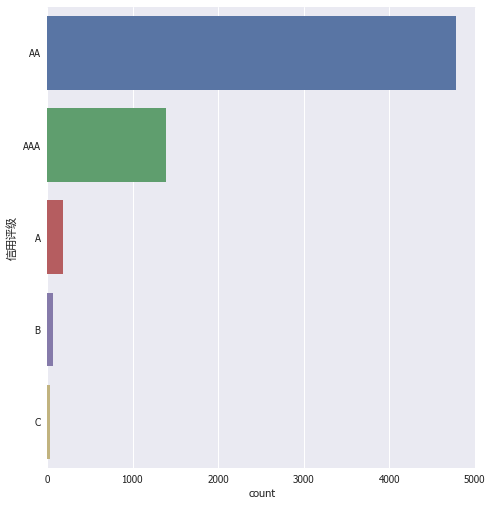

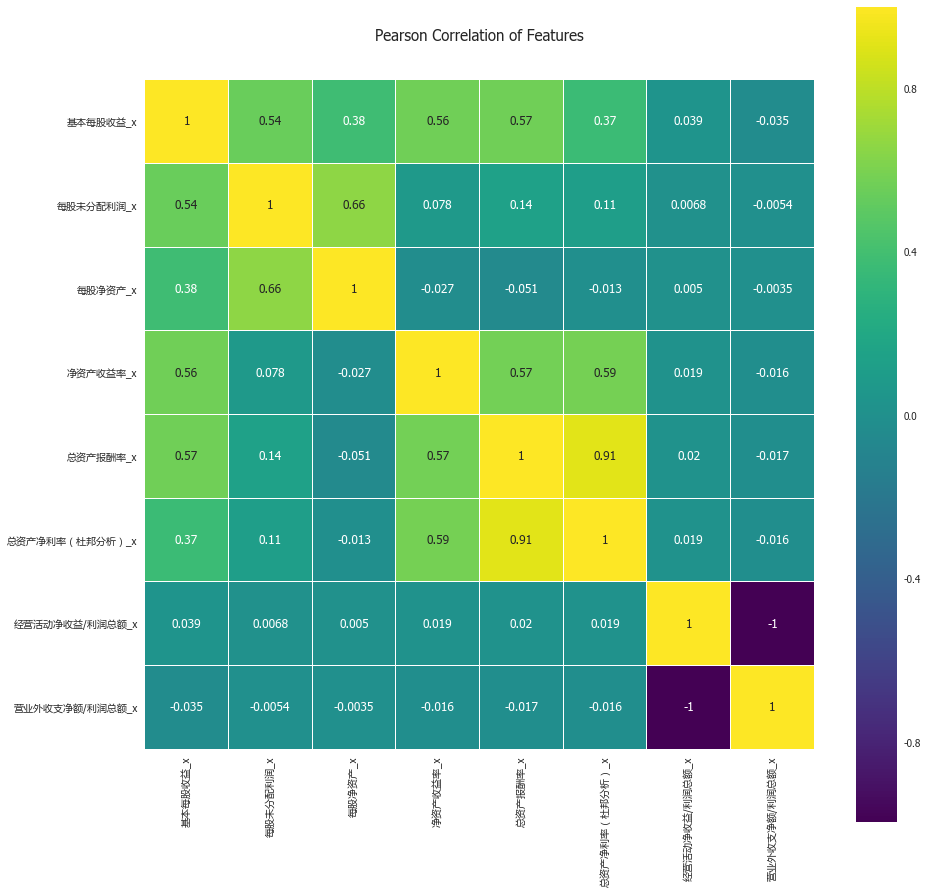

In [36]:
# 是否省份，地市会提高准确率？
b, label = encode_feature(b_halfyear)
show_corr(b.iloc[:,:10])
run(b, label, 5000)
create_feature_map(b.columns)
# calc_fscore()

[0]	train-mlogloss:1.59167	test-mlogloss:1.59226
[1]	train-mlogloss:1.57523	test-mlogloss:1.57648
[2]	train-mlogloss:1.55812	test-mlogloss:1.56002
[3]	train-mlogloss:1.54124	test-mlogloss:1.54398
[4]	train-mlogloss:1.52489	test-mlogloss:1.52831
[5]	train-mlogloss:1.50855	test-mlogloss:1.51264
[6]	train-mlogloss:1.49356	test-mlogloss:1.49851
[7]	train-mlogloss:1.47829	test-mlogloss:1.48391
[8]	train-mlogloss:1.4627	test-mlogloss:1.469
[9]	train-mlogloss:1.44766	test-mlogloss:1.45459
[10]	train-mlogloss:1.43282	test-mlogloss:1.44029
[11]	train-mlogloss:1.41829	test-mlogloss:1.42643
[12]	train-mlogloss:1.40417	test-mlogloss:1.41307
[13]	train-mlogloss:1.39049	test-mlogloss:1.39999
[14]	train-mlogloss:1.37661	test-mlogloss:1.38663
[15]	train-mlogloss:1.36342	test-mlogloss:1.37411
[16]	train-mlogloss:1.35042	test-mlogloss:1.36169
[17]	train-mlogloss:1.33797	test-mlogloss:1.34984
[18]	train-mlogloss:1.32482	test-mlogloss:1.33725
[19]	train-mlogloss:1.31191	test-mlogloss:1.32489
[20]	train-ml

[160]	train-mlogloss:0.462581	test-mlogloss:0.528403
[161]	train-mlogloss:0.459764	test-mlogloss:0.525822
[162]	train-mlogloss:0.456982	test-mlogloss:0.523284
[163]	train-mlogloss:0.454305	test-mlogloss:0.520895
[164]	train-mlogloss:0.451507	test-mlogloss:0.518302
[165]	train-mlogloss:0.448765	test-mlogloss:0.515801
[166]	train-mlogloss:0.44592	test-mlogloss:0.513145
[167]	train-mlogloss:0.443078	test-mlogloss:0.510552
[168]	train-mlogloss:0.440355	test-mlogloss:0.507999
[169]	train-mlogloss:0.437604	test-mlogloss:0.50544
[170]	train-mlogloss:0.435021	test-mlogloss:0.503115
[171]	train-mlogloss:0.43229	test-mlogloss:0.500575
[172]	train-mlogloss:0.429613	test-mlogloss:0.498072
[173]	train-mlogloss:0.427101	test-mlogloss:0.495779
[174]	train-mlogloss:0.424582	test-mlogloss:0.493497
[175]	train-mlogloss:0.422138	test-mlogloss:0.491306
[176]	train-mlogloss:0.419809	test-mlogloss:0.489164
[177]	train-mlogloss:0.417291	test-mlogloss:0.486924
[178]	train-mlogloss:0.414829	test-mlogloss:0.484

[316]	train-mlogloss:0.206453	test-mlogloss:0.296955
[317]	train-mlogloss:0.205587	test-mlogloss:0.296209
[318]	train-mlogloss:0.20468	test-mlogloss:0.295381
[319]	train-mlogloss:0.203818	test-mlogloss:0.294621
[320]	train-mlogloss:0.202988	test-mlogloss:0.293876
[321]	train-mlogloss:0.202076	test-mlogloss:0.293083
[322]	train-mlogloss:0.201296	test-mlogloss:0.292445
[323]	train-mlogloss:0.200508	test-mlogloss:0.291768
[324]	train-mlogloss:0.19967	test-mlogloss:0.291062
[325]	train-mlogloss:0.198815	test-mlogloss:0.290297
[326]	train-mlogloss:0.198039	test-mlogloss:0.289613
[327]	train-mlogloss:0.197197	test-mlogloss:0.288836
[328]	train-mlogloss:0.196386	test-mlogloss:0.288132
[329]	train-mlogloss:0.195532	test-mlogloss:0.287398
[330]	train-mlogloss:0.194697	test-mlogloss:0.286643
[331]	train-mlogloss:0.193904	test-mlogloss:0.285973
[332]	train-mlogloss:0.193104	test-mlogloss:0.285267
[333]	train-mlogloss:0.192346	test-mlogloss:0.284615
[334]	train-mlogloss:0.191507	test-mlogloss:0.28

[472]	train-mlogloss:0.118581	test-mlogloss:0.220309
[473]	train-mlogloss:0.118224	test-mlogloss:0.219983
[474]	train-mlogloss:0.117863	test-mlogloss:0.219716
[475]	train-mlogloss:0.1175	test-mlogloss:0.219394
[476]	train-mlogloss:0.117146	test-mlogloss:0.219052
[477]	train-mlogloss:0.116812	test-mlogloss:0.218783
[478]	train-mlogloss:0.116488	test-mlogloss:0.218528
[479]	train-mlogloss:0.116107	test-mlogloss:0.218175
[480]	train-mlogloss:0.115746	test-mlogloss:0.217837
[481]	train-mlogloss:0.115381	test-mlogloss:0.217545
[482]	train-mlogloss:0.115031	test-mlogloss:0.217242
[483]	train-mlogloss:0.114695	test-mlogloss:0.216968
[484]	train-mlogloss:0.11439	test-mlogloss:0.216726
[485]	train-mlogloss:0.114083	test-mlogloss:0.216471
[486]	train-mlogloss:0.113764	test-mlogloss:0.216206
[487]	train-mlogloss:0.11343	test-mlogloss:0.215902
[488]	train-mlogloss:0.113096	test-mlogloss:0.215588
[489]	train-mlogloss:0.112771	test-mlogloss:0.215273
[490]	train-mlogloss:0.112433	test-mlogloss:0.2149

[628]	train-mlogloss:0.080049	test-mlogloss:0.186072
[629]	train-mlogloss:0.079876	test-mlogloss:0.185891
[630]	train-mlogloss:0.079705	test-mlogloss:0.185728
[631]	train-mlogloss:0.079538	test-mlogloss:0.185555
[632]	train-mlogloss:0.079375	test-mlogloss:0.1854
[633]	train-mlogloss:0.079225	test-mlogloss:0.185274
[634]	train-mlogloss:0.079054	test-mlogloss:0.185141
[635]	train-mlogloss:0.078884	test-mlogloss:0.184987
[636]	train-mlogloss:0.078721	test-mlogloss:0.18481
[637]	train-mlogloss:0.078543	test-mlogloss:0.184657
[638]	train-mlogloss:0.078366	test-mlogloss:0.184459
[639]	train-mlogloss:0.078215	test-mlogloss:0.184343
[640]	train-mlogloss:0.078052	test-mlogloss:0.184188
[641]	train-mlogloss:0.077892	test-mlogloss:0.184044
[642]	train-mlogloss:0.077738	test-mlogloss:0.183888
[643]	train-mlogloss:0.077566	test-mlogloss:0.183711
[644]	train-mlogloss:0.077403	test-mlogloss:0.183586
[645]	train-mlogloss:0.077241	test-mlogloss:0.183427
[646]	train-mlogloss:0.077082	test-mlogloss:0.183

[783]	train-mlogloss:0.060068	test-mlogloss:0.167589
[784]	train-mlogloss:0.059972	test-mlogloss:0.167513
[785]	train-mlogloss:0.059884	test-mlogloss:0.167449
[786]	train-mlogloss:0.059778	test-mlogloss:0.167358
[787]	train-mlogloss:0.059675	test-mlogloss:0.167242
[788]	train-mlogloss:0.059584	test-mlogloss:0.167183
[789]	train-mlogloss:0.059491	test-mlogloss:0.167057
[790]	train-mlogloss:0.059394	test-mlogloss:0.166978
[791]	train-mlogloss:0.059302	test-mlogloss:0.166856
[792]	train-mlogloss:0.05921	test-mlogloss:0.166762
[793]	train-mlogloss:0.059107	test-mlogloss:0.166655
[794]	train-mlogloss:0.059018	test-mlogloss:0.166595
[795]	train-mlogloss:0.058931	test-mlogloss:0.166538
[796]	train-mlogloss:0.058834	test-mlogloss:0.166463
[797]	train-mlogloss:0.058748	test-mlogloss:0.166394
[798]	train-mlogloss:0.058644	test-mlogloss:0.166284
[799]	train-mlogloss:0.058553	test-mlogloss:0.166173
[800]	train-mlogloss:0.058458	test-mlogloss:0.166074
[801]	train-mlogloss:0.058378	test-mlogloss:0.1

[939]	train-mlogloss:0.047963	test-mlogloss:0.155877
[940]	train-mlogloss:0.047902	test-mlogloss:0.155822
[941]	train-mlogloss:0.047839	test-mlogloss:0.155761
[942]	train-mlogloss:0.047777	test-mlogloss:0.155701
[943]	train-mlogloss:0.047712	test-mlogloss:0.155614
[944]	train-mlogloss:0.047658	test-mlogloss:0.155555
[945]	train-mlogloss:0.047598	test-mlogloss:0.155478
[946]	train-mlogloss:0.04754	test-mlogloss:0.155413
[947]	train-mlogloss:0.047481	test-mlogloss:0.155349
[948]	train-mlogloss:0.047422	test-mlogloss:0.155273
[949]	train-mlogloss:0.047354	test-mlogloss:0.155187
[950]	train-mlogloss:0.047295	test-mlogloss:0.155122
[951]	train-mlogloss:0.04724	test-mlogloss:0.155063
[952]	train-mlogloss:0.047177	test-mlogloss:0.155
[953]	train-mlogloss:0.047126	test-mlogloss:0.154971
[954]	train-mlogloss:0.047071	test-mlogloss:0.154909
[955]	train-mlogloss:0.047009	test-mlogloss:0.154856
[956]	train-mlogloss:0.046943	test-mlogloss:0.154792
[957]	train-mlogloss:0.046882	test-mlogloss:0.15474

[1093]	train-mlogloss:0.040119	test-mlogloss:0.147717
[1094]	train-mlogloss:0.040082	test-mlogloss:0.147687
[1095]	train-mlogloss:0.040041	test-mlogloss:0.14764
[1096]	train-mlogloss:0.04	test-mlogloss:0.147598
[1097]	train-mlogloss:0.039963	test-mlogloss:0.147539
[1098]	train-mlogloss:0.039922	test-mlogloss:0.147501
[1099]	train-mlogloss:0.039875	test-mlogloss:0.147447
[1100]	train-mlogloss:0.039829	test-mlogloss:0.147402
[1101]	train-mlogloss:0.039785	test-mlogloss:0.147371
[1102]	train-mlogloss:0.039749	test-mlogloss:0.147358
[1103]	train-mlogloss:0.039706	test-mlogloss:0.147322
[1104]	train-mlogloss:0.039664	test-mlogloss:0.147287
[1105]	train-mlogloss:0.039619	test-mlogloss:0.147242
[1106]	train-mlogloss:0.039584	test-mlogloss:0.147207
[1107]	train-mlogloss:0.03954	test-mlogloss:0.147168
[1108]	train-mlogloss:0.039499	test-mlogloss:0.147116
[1109]	train-mlogloss:0.039457	test-mlogloss:0.147074
[1110]	train-mlogloss:0.039411	test-mlogloss:0.147009
[1111]	train-mlogloss:0.039375	tes

[1246]	train-mlogloss:0.034707	test-mlogloss:0.141908
[1247]	train-mlogloss:0.034674	test-mlogloss:0.141897
[1248]	train-mlogloss:0.034648	test-mlogloss:0.141866
[1249]	train-mlogloss:0.034618	test-mlogloss:0.141827
[1250]	train-mlogloss:0.034588	test-mlogloss:0.141805
[1251]	train-mlogloss:0.034556	test-mlogloss:0.141776
[1252]	train-mlogloss:0.034523	test-mlogloss:0.141744
[1253]	train-mlogloss:0.034498	test-mlogloss:0.141716
[1254]	train-mlogloss:0.034473	test-mlogloss:0.141688
[1255]	train-mlogloss:0.03444	test-mlogloss:0.141639
[1256]	train-mlogloss:0.034411	test-mlogloss:0.141618
[1257]	train-mlogloss:0.034386	test-mlogloss:0.141601
[1258]	train-mlogloss:0.034356	test-mlogloss:0.141567
[1259]	train-mlogloss:0.034331	test-mlogloss:0.141536
[1260]	train-mlogloss:0.034305	test-mlogloss:0.141506
[1261]	train-mlogloss:0.034274	test-mlogloss:0.141482
[1262]	train-mlogloss:0.034247	test-mlogloss:0.141437
[1263]	train-mlogloss:0.034214	test-mlogloss:0.141392
[1264]	train-mlogloss:0.03418

[1399]	train-mlogloss:0.030842	test-mlogloss:0.137945
[1400]	train-mlogloss:0.030822	test-mlogloss:0.137931
[1401]	train-mlogloss:0.030801	test-mlogloss:0.137911
[1402]	train-mlogloss:0.030774	test-mlogloss:0.137885
[1403]	train-mlogloss:0.030749	test-mlogloss:0.13786
[1404]	train-mlogloss:0.030725	test-mlogloss:0.137817
[1405]	train-mlogloss:0.0307	test-mlogloss:0.137801
[1406]	train-mlogloss:0.030678	test-mlogloss:0.137772
[1407]	train-mlogloss:0.03066	test-mlogloss:0.137769
[1408]	train-mlogloss:0.030637	test-mlogloss:0.137731
[1409]	train-mlogloss:0.030617	test-mlogloss:0.137714
[1410]	train-mlogloss:0.030593	test-mlogloss:0.137677
[1411]	train-mlogloss:0.030571	test-mlogloss:0.137662
[1412]	train-mlogloss:0.030549	test-mlogloss:0.137642
[1413]	train-mlogloss:0.030527	test-mlogloss:0.137618
[1414]	train-mlogloss:0.030506	test-mlogloss:0.137612
[1415]	train-mlogloss:0.030484	test-mlogloss:0.137564
[1416]	train-mlogloss:0.030458	test-mlogloss:0.137516
[1417]	train-mlogloss:0.030434	t

[1552]	train-mlogloss:0.027889	test-mlogloss:0.134629
[1553]	train-mlogloss:0.027871	test-mlogloss:0.134603
[1554]	train-mlogloss:0.027856	test-mlogloss:0.134585
[1555]	train-mlogloss:0.027839	test-mlogloss:0.13455
[1556]	train-mlogloss:0.027828	test-mlogloss:0.13454
[1557]	train-mlogloss:0.027809	test-mlogloss:0.134508
[1558]	train-mlogloss:0.027796	test-mlogloss:0.134491
[1559]	train-mlogloss:0.027782	test-mlogloss:0.134493
[1560]	train-mlogloss:0.027762	test-mlogloss:0.134459
[1561]	train-mlogloss:0.027747	test-mlogloss:0.134445
[1562]	train-mlogloss:0.027728	test-mlogloss:0.134418
[1563]	train-mlogloss:0.027712	test-mlogloss:0.134413
[1564]	train-mlogloss:0.027698	test-mlogloss:0.134403
[1565]	train-mlogloss:0.02768	test-mlogloss:0.134384
[1566]	train-mlogloss:0.027664	test-mlogloss:0.13437
[1567]	train-mlogloss:0.027647	test-mlogloss:0.134354
[1568]	train-mlogloss:0.027634	test-mlogloss:0.134369
[1569]	train-mlogloss:0.02762	test-mlogloss:0.134359
[1570]	train-mlogloss:0.027607	te

[1705]	train-mlogloss:0.025597	test-mlogloss:0.131909
[1706]	train-mlogloss:0.025584	test-mlogloss:0.131888
[1707]	train-mlogloss:0.025568	test-mlogloss:0.131867
[1708]	train-mlogloss:0.025553	test-mlogloss:0.131854
[1709]	train-mlogloss:0.025543	test-mlogloss:0.131856
[1710]	train-mlogloss:0.025532	test-mlogloss:0.131853
[1711]	train-mlogloss:0.02552	test-mlogloss:0.131846
[1712]	train-mlogloss:0.025507	test-mlogloss:0.131833
[1713]	train-mlogloss:0.025493	test-mlogloss:0.131812
[1714]	train-mlogloss:0.02548	test-mlogloss:0.131808
[1715]	train-mlogloss:0.025468	test-mlogloss:0.131795
[1716]	train-mlogloss:0.025454	test-mlogloss:0.131782
[1717]	train-mlogloss:0.025443	test-mlogloss:0.131776
[1718]	train-mlogloss:0.025432	test-mlogloss:0.131767
[1719]	train-mlogloss:0.025418	test-mlogloss:0.131763
[1720]	train-mlogloss:0.025405	test-mlogloss:0.131732
[1721]	train-mlogloss:0.025393	test-mlogloss:0.131726
[1722]	train-mlogloss:0.025377	test-mlogloss:0.131699
[1723]	train-mlogloss:0.025362

[1858]	train-mlogloss:0.023795	test-mlogloss:0.129859
[1859]	train-mlogloss:0.023788	test-mlogloss:0.129846
[1860]	train-mlogloss:0.023779	test-mlogloss:0.129839
[1861]	train-mlogloss:0.023771	test-mlogloss:0.129832
[1862]	train-mlogloss:0.023762	test-mlogloss:0.129818
[1863]	train-mlogloss:0.023753	test-mlogloss:0.129821
[1864]	train-mlogloss:0.023745	test-mlogloss:0.129815
[1865]	train-mlogloss:0.023736	test-mlogloss:0.129829
[1866]	train-mlogloss:0.02373	test-mlogloss:0.129827
[1867]	train-mlogloss:0.02372	test-mlogloss:0.129823
[1868]	train-mlogloss:0.023709	test-mlogloss:0.129796
[1869]	train-mlogloss:0.0237	test-mlogloss:0.129808
[1870]	train-mlogloss:0.02369	test-mlogloss:0.129808
[1871]	train-mlogloss:0.02368	test-mlogloss:0.129789
[1872]	train-mlogloss:0.023669	test-mlogloss:0.129807
[1873]	train-mlogloss:0.02366	test-mlogloss:0.129793
[1874]	train-mlogloss:0.023652	test-mlogloss:0.129786
[1875]	train-mlogloss:0.023641	test-mlogloss:0.129782
[1876]	train-mlogloss:0.02363	test-

[2011]	train-mlogloss:0.022375	test-mlogloss:0.128238
[2012]	train-mlogloss:0.022367	test-mlogloss:0.128224
[2013]	train-mlogloss:0.02236	test-mlogloss:0.128199
[2014]	train-mlogloss:0.022353	test-mlogloss:0.128194
[2015]	train-mlogloss:0.022343	test-mlogloss:0.128188
[2016]	train-mlogloss:0.022335	test-mlogloss:0.128181
[2017]	train-mlogloss:0.022327	test-mlogloss:0.128174
[2018]	train-mlogloss:0.022321	test-mlogloss:0.128164
[2019]	train-mlogloss:0.022312	test-mlogloss:0.128155
[2020]	train-mlogloss:0.022302	test-mlogloss:0.128131
[2021]	train-mlogloss:0.022291	test-mlogloss:0.128108
[2022]	train-mlogloss:0.022283	test-mlogloss:0.128086
[2023]	train-mlogloss:0.022274	test-mlogloss:0.128087
[2024]	train-mlogloss:0.022264	test-mlogloss:0.128073
[2025]	train-mlogloss:0.022256	test-mlogloss:0.128058
[2026]	train-mlogloss:0.022248	test-mlogloss:0.128043
[2027]	train-mlogloss:0.022238	test-mlogloss:0.128033
[2028]	train-mlogloss:0.022227	test-mlogloss:0.127997
[2029]	train-mlogloss:0.02222

[2164]	train-mlogloss:0.021186	test-mlogloss:0.126729
[2165]	train-mlogloss:0.021177	test-mlogloss:0.126706
[2166]	train-mlogloss:0.021169	test-mlogloss:0.126701
[2167]	train-mlogloss:0.021162	test-mlogloss:0.126687
[2168]	train-mlogloss:0.021157	test-mlogloss:0.126684
[2169]	train-mlogloss:0.02115	test-mlogloss:0.126667
[2170]	train-mlogloss:0.021141	test-mlogloss:0.126651
[2171]	train-mlogloss:0.021135	test-mlogloss:0.126651
[2172]	train-mlogloss:0.021126	test-mlogloss:0.126644
[2173]	train-mlogloss:0.021121	test-mlogloss:0.12665
[2174]	train-mlogloss:0.021112	test-mlogloss:0.12665
[2175]	train-mlogloss:0.021108	test-mlogloss:0.126643
[2176]	train-mlogloss:0.021101	test-mlogloss:0.12663
[2177]	train-mlogloss:0.021095	test-mlogloss:0.126631
[2178]	train-mlogloss:0.02109	test-mlogloss:0.126628
[2179]	train-mlogloss:0.021083	test-mlogloss:0.126624
[2180]	train-mlogloss:0.021076	test-mlogloss:0.126615
[2181]	train-mlogloss:0.021069	test-mlogloss:0.126605
[2182]	train-mlogloss:0.021063	te

[2317]	train-mlogloss:0.02019	test-mlogloss:0.125549
[2318]	train-mlogloss:0.020185	test-mlogloss:0.125554
[2319]	train-mlogloss:0.020179	test-mlogloss:0.125541
[2320]	train-mlogloss:0.020173	test-mlogloss:0.125535
[2321]	train-mlogloss:0.020166	test-mlogloss:0.125529
[2322]	train-mlogloss:0.020161	test-mlogloss:0.125509
[2323]	train-mlogloss:0.020156	test-mlogloss:0.125521
[2324]	train-mlogloss:0.020152	test-mlogloss:0.125521
[2325]	train-mlogloss:0.020148	test-mlogloss:0.125509
[2326]	train-mlogloss:0.020142	test-mlogloss:0.125498
[2327]	train-mlogloss:0.020135	test-mlogloss:0.125491
[2328]	train-mlogloss:0.020129	test-mlogloss:0.125481
[2329]	train-mlogloss:0.020125	test-mlogloss:0.125481
[2330]	train-mlogloss:0.02012	test-mlogloss:0.125469
[2331]	train-mlogloss:0.020114	test-mlogloss:0.125475
[2332]	train-mlogloss:0.020108	test-mlogloss:0.125469
[2333]	train-mlogloss:0.020102	test-mlogloss:0.12547
[2334]	train-mlogloss:0.020098	test-mlogloss:0.125464
[2335]	train-mlogloss:0.020093	

[2470]	train-mlogloss:0.019381	test-mlogloss:0.124595
[2471]	train-mlogloss:0.019377	test-mlogloss:0.124583
[2472]	train-mlogloss:0.019371	test-mlogloss:0.124578
[2473]	train-mlogloss:0.019366	test-mlogloss:0.124563
[2474]	train-mlogloss:0.01936	test-mlogloss:0.124554
[2475]	train-mlogloss:0.019354	test-mlogloss:0.124555
[2476]	train-mlogloss:0.01935	test-mlogloss:0.12455
[2477]	train-mlogloss:0.019343	test-mlogloss:0.124542
[2478]	train-mlogloss:0.019338	test-mlogloss:0.124543
[2479]	train-mlogloss:0.019333	test-mlogloss:0.124536
[2480]	train-mlogloss:0.019329	test-mlogloss:0.124529
[2481]	train-mlogloss:0.019323	test-mlogloss:0.124524
[2482]	train-mlogloss:0.019316	test-mlogloss:0.124524
[2483]	train-mlogloss:0.01931	test-mlogloss:0.124519
[2484]	train-mlogloss:0.019303	test-mlogloss:0.124504
[2485]	train-mlogloss:0.019298	test-mlogloss:0.124483
[2486]	train-mlogloss:0.019294	test-mlogloss:0.124473
[2487]	train-mlogloss:0.019287	test-mlogloss:0.124466
[2488]	train-mlogloss:0.019284	t

[2623]	train-mlogloss:0.018696	test-mlogloss:0.123927
[2624]	train-mlogloss:0.018692	test-mlogloss:0.123912
[2625]	train-mlogloss:0.018689	test-mlogloss:0.123909
[2626]	train-mlogloss:0.018686	test-mlogloss:0.123902
[2627]	train-mlogloss:0.018683	test-mlogloss:0.123904
[2628]	train-mlogloss:0.018679	test-mlogloss:0.123904
[2629]	train-mlogloss:0.018677	test-mlogloss:0.123897
[2630]	train-mlogloss:0.018673	test-mlogloss:0.123887
[2631]	train-mlogloss:0.01867	test-mlogloss:0.123881
[2632]	train-mlogloss:0.018665	test-mlogloss:0.123873
[2633]	train-mlogloss:0.01866	test-mlogloss:0.123866
[2634]	train-mlogloss:0.018656	test-mlogloss:0.123861
[2635]	train-mlogloss:0.018651	test-mlogloss:0.123849
[2636]	train-mlogloss:0.018647	test-mlogloss:0.123847
[2637]	train-mlogloss:0.018644	test-mlogloss:0.123835
[2638]	train-mlogloss:0.01864	test-mlogloss:0.123833
[2639]	train-mlogloss:0.018636	test-mlogloss:0.123819
[2640]	train-mlogloss:0.01863	test-mlogloss:0.123813
[2641]	train-mlogloss:0.018627	t

[2776]	train-mlogloss:0.018121	test-mlogloss:0.123133
[2777]	train-mlogloss:0.018118	test-mlogloss:0.123126
[2778]	train-mlogloss:0.018114	test-mlogloss:0.123141
[2779]	train-mlogloss:0.01811	test-mlogloss:0.123127
[2780]	train-mlogloss:0.018107	test-mlogloss:0.123129
[2781]	train-mlogloss:0.018104	test-mlogloss:0.123133
[2782]	train-mlogloss:0.018099	test-mlogloss:0.123131
[2783]	train-mlogloss:0.018098	test-mlogloss:0.123132
[2784]	train-mlogloss:0.018094	test-mlogloss:0.123134
[2785]	train-mlogloss:0.018092	test-mlogloss:0.123127
[2786]	train-mlogloss:0.018089	test-mlogloss:0.123132
[2787]	train-mlogloss:0.018085	test-mlogloss:0.123132
[2788]	train-mlogloss:0.018083	test-mlogloss:0.123135
[2789]	train-mlogloss:0.018077	test-mlogloss:0.123115
[2790]	train-mlogloss:0.018074	test-mlogloss:0.123117
[2791]	train-mlogloss:0.018072	test-mlogloss:0.123105
[2792]	train-mlogloss:0.018069	test-mlogloss:0.1231
[2793]	train-mlogloss:0.018065	test-mlogloss:0.123101
[2794]	train-mlogloss:0.018063	

[2929]	train-mlogloss:0.017632	test-mlogloss:0.122646
[2930]	train-mlogloss:0.017628	test-mlogloss:0.122632
[2931]	train-mlogloss:0.017627	test-mlogloss:0.122629
[2932]	train-mlogloss:0.017623	test-mlogloss:0.122616
[2933]	train-mlogloss:0.01762	test-mlogloss:0.122607
[2934]	train-mlogloss:0.017616	test-mlogloss:0.122601
[2935]	train-mlogloss:0.017614	test-mlogloss:0.12259
[2936]	train-mlogloss:0.017611	test-mlogloss:0.122592
[2937]	train-mlogloss:0.017609	test-mlogloss:0.122588
[2938]	train-mlogloss:0.017605	test-mlogloss:0.122577
[2939]	train-mlogloss:0.017603	test-mlogloss:0.122568
[2940]	train-mlogloss:0.0176	test-mlogloss:0.122567
[2941]	train-mlogloss:0.017597	test-mlogloss:0.122561
[2942]	train-mlogloss:0.017595	test-mlogloss:0.122561
[2943]	train-mlogloss:0.017592	test-mlogloss:0.122552
[2944]	train-mlogloss:0.017589	test-mlogloss:0.122555
[2945]	train-mlogloss:0.017585	test-mlogloss:0.122547
[2946]	train-mlogloss:0.017582	test-mlogloss:0.122546
[2947]	train-mlogloss:0.01758	te

[3082]	train-mlogloss:0.017199	test-mlogloss:0.122212
[3083]	train-mlogloss:0.017195	test-mlogloss:0.122201
[3084]	train-mlogloss:0.017193	test-mlogloss:0.122187
[3085]	train-mlogloss:0.01719	test-mlogloss:0.122187
[3086]	train-mlogloss:0.017188	test-mlogloss:0.122185
[3087]	train-mlogloss:0.017185	test-mlogloss:0.122188
[3088]	train-mlogloss:0.017182	test-mlogloss:0.122185
[3089]	train-mlogloss:0.017179	test-mlogloss:0.122184
[3090]	train-mlogloss:0.017178	test-mlogloss:0.122179
[3091]	train-mlogloss:0.017176	test-mlogloss:0.122181
[3092]	train-mlogloss:0.017172	test-mlogloss:0.122173
[3093]	train-mlogloss:0.017171	test-mlogloss:0.122174
[3094]	train-mlogloss:0.017169	test-mlogloss:0.122179
[3095]	train-mlogloss:0.017168	test-mlogloss:0.122179
[3096]	train-mlogloss:0.017165	test-mlogloss:0.122187
[3097]	train-mlogloss:0.017162	test-mlogloss:0.122195
[3098]	train-mlogloss:0.01716	test-mlogloss:0.122192
[3099]	train-mlogloss:0.017155	test-mlogloss:0.122188
[3100]	train-mlogloss:0.017153

[3235]	train-mlogloss:0.016827	test-mlogloss:0.12187
[3236]	train-mlogloss:0.016824	test-mlogloss:0.121869
[3237]	train-mlogloss:0.016822	test-mlogloss:0.121865
[3238]	train-mlogloss:0.016818	test-mlogloss:0.12186
[3239]	train-mlogloss:0.016817	test-mlogloss:0.121862
[3240]	train-mlogloss:0.016815	test-mlogloss:0.121864
[3241]	train-mlogloss:0.016813	test-mlogloss:0.121861
[3242]	train-mlogloss:0.01681	test-mlogloss:0.121851
[3243]	train-mlogloss:0.016809	test-mlogloss:0.121848
[3244]	train-mlogloss:0.016806	test-mlogloss:0.121855
[3245]	train-mlogloss:0.016802	test-mlogloss:0.121851
[3246]	train-mlogloss:0.0168	test-mlogloss:0.121849
[3247]	train-mlogloss:0.016799	test-mlogloss:0.121848
[3248]	train-mlogloss:0.016798	test-mlogloss:0.121844
[3249]	train-mlogloss:0.016796	test-mlogloss:0.121841
[3250]	train-mlogloss:0.016795	test-mlogloss:0.121839
[3251]	train-mlogloss:0.016793	test-mlogloss:0.121837
[3252]	train-mlogloss:0.016791	test-mlogloss:0.121842
[3253]	train-mlogloss:0.016788	te

[3388]	train-mlogloss:0.016502	test-mlogloss:0.121552
[3389]	train-mlogloss:0.0165	test-mlogloss:0.121546
[3390]	train-mlogloss:0.016498	test-mlogloss:0.121538
[3391]	train-mlogloss:0.016496	test-mlogloss:0.121532
[3392]	train-mlogloss:0.016492	test-mlogloss:0.121524
[3393]	train-mlogloss:0.016491	test-mlogloss:0.121514
[3394]	train-mlogloss:0.016489	test-mlogloss:0.121503
[3395]	train-mlogloss:0.016486	test-mlogloss:0.121502
[3396]	train-mlogloss:0.016485	test-mlogloss:0.121504
[3397]	train-mlogloss:0.016484	test-mlogloss:0.121502
[3398]	train-mlogloss:0.016482	test-mlogloss:0.121504
[3399]	train-mlogloss:0.016479	test-mlogloss:0.121495
[3400]	train-mlogloss:0.016477	test-mlogloss:0.121485
[3401]	train-mlogloss:0.016475	test-mlogloss:0.12148
[3402]	train-mlogloss:0.016474	test-mlogloss:0.121473
[3403]	train-mlogloss:0.016471	test-mlogloss:0.121472
[3404]	train-mlogloss:0.01647	test-mlogloss:0.121475
[3405]	train-mlogloss:0.016468	test-mlogloss:0.121466
[3406]	train-mlogloss:0.016466	t

[3541]	train-mlogloss:0.016206	test-mlogloss:0.121181
[3542]	train-mlogloss:0.016205	test-mlogloss:0.121189
[3543]	train-mlogloss:0.016203	test-mlogloss:0.121191
[3544]	train-mlogloss:0.016201	test-mlogloss:0.121187
[3545]	train-mlogloss:0.016199	test-mlogloss:0.121179
[3546]	train-mlogloss:0.016197	test-mlogloss:0.121175
[3547]	train-mlogloss:0.016194	test-mlogloss:0.121182
[3548]	train-mlogloss:0.016191	test-mlogloss:0.121181
[3549]	train-mlogloss:0.016189	test-mlogloss:0.12118
[3550]	train-mlogloss:0.016185	test-mlogloss:0.12118
[3551]	train-mlogloss:0.016182	test-mlogloss:0.121179
[3552]	train-mlogloss:0.016179	test-mlogloss:0.121173
[3553]	train-mlogloss:0.016177	test-mlogloss:0.121167
[3554]	train-mlogloss:0.016176	test-mlogloss:0.12117
[3555]	train-mlogloss:0.016172	test-mlogloss:0.121171
[3556]	train-mlogloss:0.016171	test-mlogloss:0.121168
[3557]	train-mlogloss:0.01617	test-mlogloss:0.121163
[3558]	train-mlogloss:0.016167	test-mlogloss:0.121163
[3559]	train-mlogloss:0.016166	t

[3694]	train-mlogloss:0.015906	test-mlogloss:0.120842
[3695]	train-mlogloss:0.015904	test-mlogloss:0.120839
[3696]	train-mlogloss:0.015903	test-mlogloss:0.120841
[3697]	train-mlogloss:0.015901	test-mlogloss:0.120834
[3698]	train-mlogloss:0.0159	test-mlogloss:0.12084
[3699]	train-mlogloss:0.015899	test-mlogloss:0.120843
[3700]	train-mlogloss:0.015898	test-mlogloss:0.120845
[3701]	train-mlogloss:0.015896	test-mlogloss:0.120836
[3702]	train-mlogloss:0.015894	test-mlogloss:0.120834
[3703]	train-mlogloss:0.015892	test-mlogloss:0.120825
[3704]	train-mlogloss:0.015891	test-mlogloss:0.120822
[3705]	train-mlogloss:0.015888	test-mlogloss:0.120831
[3706]	train-mlogloss:0.015887	test-mlogloss:0.120838
[3707]	train-mlogloss:0.015885	test-mlogloss:0.120842
[3708]	train-mlogloss:0.015883	test-mlogloss:0.120838
[3709]	train-mlogloss:0.015882	test-mlogloss:0.120836
[3710]	train-mlogloss:0.015881	test-mlogloss:0.120835
[3711]	train-mlogloss:0.015878	test-mlogloss:0.120817
[3712]	train-mlogloss:0.015876	

[3847]	train-mlogloss:0.01567	test-mlogloss:0.120628
[3848]	train-mlogloss:0.015669	test-mlogloss:0.120631
[3849]	train-mlogloss:0.015668	test-mlogloss:0.120624
[3850]	train-mlogloss:0.015666	test-mlogloss:0.120617
[3851]	train-mlogloss:0.015664	test-mlogloss:0.12061
[3852]	train-mlogloss:0.015662	test-mlogloss:0.1206
[3853]	train-mlogloss:0.015661	test-mlogloss:0.120593
[3854]	train-mlogloss:0.015658	test-mlogloss:0.12059
[3855]	train-mlogloss:0.015656	test-mlogloss:0.120592
[3856]	train-mlogloss:0.015653	test-mlogloss:0.120594
[3857]	train-mlogloss:0.015652	test-mlogloss:0.120589
[3858]	train-mlogloss:0.015651	test-mlogloss:0.12059
[3859]	train-mlogloss:0.01565	test-mlogloss:0.12059
[3860]	train-mlogloss:0.015649	test-mlogloss:0.120588
[3861]	train-mlogloss:0.015647	test-mlogloss:0.120586
[3862]	train-mlogloss:0.015645	test-mlogloss:0.120583
[3863]	train-mlogloss:0.015644	test-mlogloss:0.120581
[3864]	train-mlogloss:0.015644	test-mlogloss:0.120577
[3865]	train-mlogloss:0.015642	test-

[4000]	train-mlogloss:0.015456	test-mlogloss:0.120384
[4001]	train-mlogloss:0.015456	test-mlogloss:0.120382
[4002]	train-mlogloss:0.015455	test-mlogloss:0.120375
[4003]	train-mlogloss:0.015453	test-mlogloss:0.120372
[4004]	train-mlogloss:0.015452	test-mlogloss:0.120375
[4005]	train-mlogloss:0.015451	test-mlogloss:0.120378
[4006]	train-mlogloss:0.015449	test-mlogloss:0.120374
[4007]	train-mlogloss:0.015448	test-mlogloss:0.120375
[4008]	train-mlogloss:0.015447	test-mlogloss:0.120372
[4009]	train-mlogloss:0.015446	test-mlogloss:0.12037
[4010]	train-mlogloss:0.015444	test-mlogloss:0.120363
[4011]	train-mlogloss:0.015443	test-mlogloss:0.120361
[4012]	train-mlogloss:0.015442	test-mlogloss:0.120356
[4013]	train-mlogloss:0.01544	test-mlogloss:0.120352
[4014]	train-mlogloss:0.015437	test-mlogloss:0.120338
[4015]	train-mlogloss:0.015436	test-mlogloss:0.120341
[4016]	train-mlogloss:0.015434	test-mlogloss:0.120337
[4017]	train-mlogloss:0.015432	test-mlogloss:0.120333
[4018]	train-mlogloss:0.015431

[4153]	train-mlogloss:0.015258	test-mlogloss:0.120142
[4154]	train-mlogloss:0.015256	test-mlogloss:0.120141
[4155]	train-mlogloss:0.015255	test-mlogloss:0.120131
[4156]	train-mlogloss:0.015254	test-mlogloss:0.120131
[4157]	train-mlogloss:0.015253	test-mlogloss:0.120133
[4158]	train-mlogloss:0.015252	test-mlogloss:0.120132
[4159]	train-mlogloss:0.015252	test-mlogloss:0.120136
[4160]	train-mlogloss:0.015251	test-mlogloss:0.120133
[4161]	train-mlogloss:0.01525	test-mlogloss:0.120132
[4162]	train-mlogloss:0.015249	test-mlogloss:0.120138
[4163]	train-mlogloss:0.015249	test-mlogloss:0.120134
[4164]	train-mlogloss:0.015247	test-mlogloss:0.12014
[4165]	train-mlogloss:0.015247	test-mlogloss:0.120138
[4166]	train-mlogloss:0.015245	test-mlogloss:0.120133
[4167]	train-mlogloss:0.015244	test-mlogloss:0.120125
[4168]	train-mlogloss:0.015242	test-mlogloss:0.12012
[4169]	train-mlogloss:0.01524	test-mlogloss:0.12012
[4170]	train-mlogloss:0.015238	test-mlogloss:0.120116
[4171]	train-mlogloss:0.015238	te

[4306]	train-mlogloss:0.015083	test-mlogloss:0.119919
[4307]	train-mlogloss:0.015082	test-mlogloss:0.119923
[4308]	train-mlogloss:0.015081	test-mlogloss:0.119924
[4309]	train-mlogloss:0.01508	test-mlogloss:0.119923
[4310]	train-mlogloss:0.015079	test-mlogloss:0.11992
[4311]	train-mlogloss:0.015077	test-mlogloss:0.119919
[4312]	train-mlogloss:0.015077	test-mlogloss:0.119924
[4313]	train-mlogloss:0.015074	test-mlogloss:0.119912
[4314]	train-mlogloss:0.015072	test-mlogloss:0.119902
[4315]	train-mlogloss:0.015071	test-mlogloss:0.119902
[4316]	train-mlogloss:0.015069	test-mlogloss:0.119892
[4317]	train-mlogloss:0.015067	test-mlogloss:0.11989
[4318]	train-mlogloss:0.015066	test-mlogloss:0.119884
[4319]	train-mlogloss:0.015064	test-mlogloss:0.119886
[4320]	train-mlogloss:0.015063	test-mlogloss:0.119881
[4321]	train-mlogloss:0.015061	test-mlogloss:0.119881
[4322]	train-mlogloss:0.01506	test-mlogloss:0.119887
[4323]	train-mlogloss:0.015058	test-mlogloss:0.119882
[4324]	train-mlogloss:0.015058	t

[4459]	train-mlogloss:0.014928	test-mlogloss:0.119754
[4460]	train-mlogloss:0.014927	test-mlogloss:0.119749
[4461]	train-mlogloss:0.014926	test-mlogloss:0.119752
[4462]	train-mlogloss:0.014925	test-mlogloss:0.119753
[4463]	train-mlogloss:0.014924	test-mlogloss:0.119747
[4464]	train-mlogloss:0.014923	test-mlogloss:0.119744
[4465]	train-mlogloss:0.014921	test-mlogloss:0.11975
[4466]	train-mlogloss:0.01492	test-mlogloss:0.119756
[4467]	train-mlogloss:0.014918	test-mlogloss:0.119758
[4468]	train-mlogloss:0.014915	test-mlogloss:0.119754
[4469]	train-mlogloss:0.014914	test-mlogloss:0.119749
[4470]	train-mlogloss:0.014914	test-mlogloss:0.119752
[4471]	train-mlogloss:0.014913	test-mlogloss:0.119755
[4472]	train-mlogloss:0.014912	test-mlogloss:0.119759
[4473]	train-mlogloss:0.014911	test-mlogloss:0.119767
[4474]	train-mlogloss:0.01491	test-mlogloss:0.11976
[4475]	train-mlogloss:0.014909	test-mlogloss:0.119766
[4476]	train-mlogloss:0.014908	test-mlogloss:0.119765
[4477]	train-mlogloss:0.014906	t

[4612]	train-mlogloss:0.014781	test-mlogloss:0.119711
[4613]	train-mlogloss:0.01478	test-mlogloss:0.119712
[4614]	train-mlogloss:0.014779	test-mlogloss:0.119715
[4615]	train-mlogloss:0.014777	test-mlogloss:0.119707
[4616]	train-mlogloss:0.014776	test-mlogloss:0.119711
[4617]	train-mlogloss:0.014775	test-mlogloss:0.119702
[4618]	train-mlogloss:0.014774	test-mlogloss:0.119701
[4619]	train-mlogloss:0.014773	test-mlogloss:0.119703
[4620]	train-mlogloss:0.014772	test-mlogloss:0.1197
[4621]	train-mlogloss:0.014771	test-mlogloss:0.119697
[4622]	train-mlogloss:0.014771	test-mlogloss:0.119692
[4623]	train-mlogloss:0.014769	test-mlogloss:0.119687
[4624]	train-mlogloss:0.014769	test-mlogloss:0.119694
[4625]	train-mlogloss:0.014769	test-mlogloss:0.119693
[4626]	train-mlogloss:0.014768	test-mlogloss:0.119689
[4627]	train-mlogloss:0.014767	test-mlogloss:0.119691
[4628]	train-mlogloss:0.014766	test-mlogloss:0.119691
[4629]	train-mlogloss:0.014765	test-mlogloss:0.119682
[4630]	train-mlogloss:0.014763	

[4765]	train-mlogloss:0.014635	test-mlogloss:0.119581
[4766]	train-mlogloss:0.014634	test-mlogloss:0.119581
[4767]	train-mlogloss:0.014634	test-mlogloss:0.119589
[4768]	train-mlogloss:0.014632	test-mlogloss:0.11959
[4769]	train-mlogloss:0.014631	test-mlogloss:0.119586
[4770]	train-mlogloss:0.01463	test-mlogloss:0.119577
[4771]	train-mlogloss:0.014629	test-mlogloss:0.119576
[4772]	train-mlogloss:0.014628	test-mlogloss:0.11957
[4773]	train-mlogloss:0.014626	test-mlogloss:0.119568
[4774]	train-mlogloss:0.014626	test-mlogloss:0.119567
[4775]	train-mlogloss:0.014626	test-mlogloss:0.119569
[4776]	train-mlogloss:0.014625	test-mlogloss:0.11957
[4777]	train-mlogloss:0.014624	test-mlogloss:0.119562
[4778]	train-mlogloss:0.014623	test-mlogloss:0.119566
[4779]	train-mlogloss:0.014623	test-mlogloss:0.119563
[4780]	train-mlogloss:0.014622	test-mlogloss:0.119564
[4781]	train-mlogloss:0.014621	test-mlogloss:0.11957
[4782]	train-mlogloss:0.014619	test-mlogloss:0.119572
[4783]	train-mlogloss:0.014619	te

[4918]	train-mlogloss:0.014501	test-mlogloss:0.119473
[4919]	train-mlogloss:0.0145	test-mlogloss:0.119473
[4920]	train-mlogloss:0.014499	test-mlogloss:0.119475
[4921]	train-mlogloss:0.014498	test-mlogloss:0.119479
[4922]	train-mlogloss:0.014497	test-mlogloss:0.119475
[4923]	train-mlogloss:0.014497	test-mlogloss:0.119475
[4924]	train-mlogloss:0.014497	test-mlogloss:0.119471
[4925]	train-mlogloss:0.014495	test-mlogloss:0.119472
[4926]	train-mlogloss:0.014494	test-mlogloss:0.119467
[4927]	train-mlogloss:0.014493	test-mlogloss:0.119465
[4928]	train-mlogloss:0.014493	test-mlogloss:0.119467
[4929]	train-mlogloss:0.014491	test-mlogloss:0.119466
[4930]	train-mlogloss:0.01449	test-mlogloss:0.119478
[4931]	train-mlogloss:0.014489	test-mlogloss:0.119475
[4932]	train-mlogloss:0.014488	test-mlogloss:0.119484
[4933]	train-mlogloss:0.014487	test-mlogloss:0.119484
[4934]	train-mlogloss:0.014487	test-mlogloss:0.119478
[4935]	train-mlogloss:0.014486	test-mlogloss:0.119484
[4936]	train-mlogloss:0.014485	

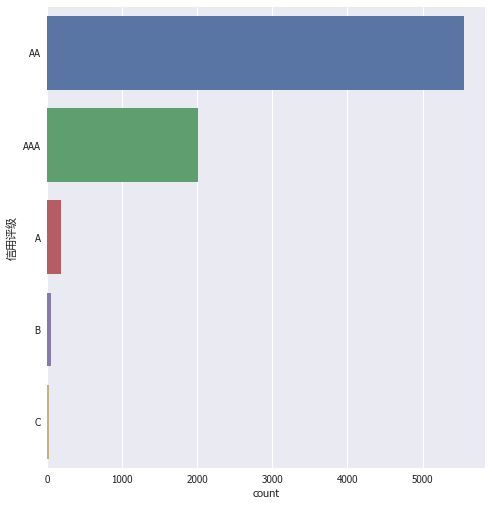

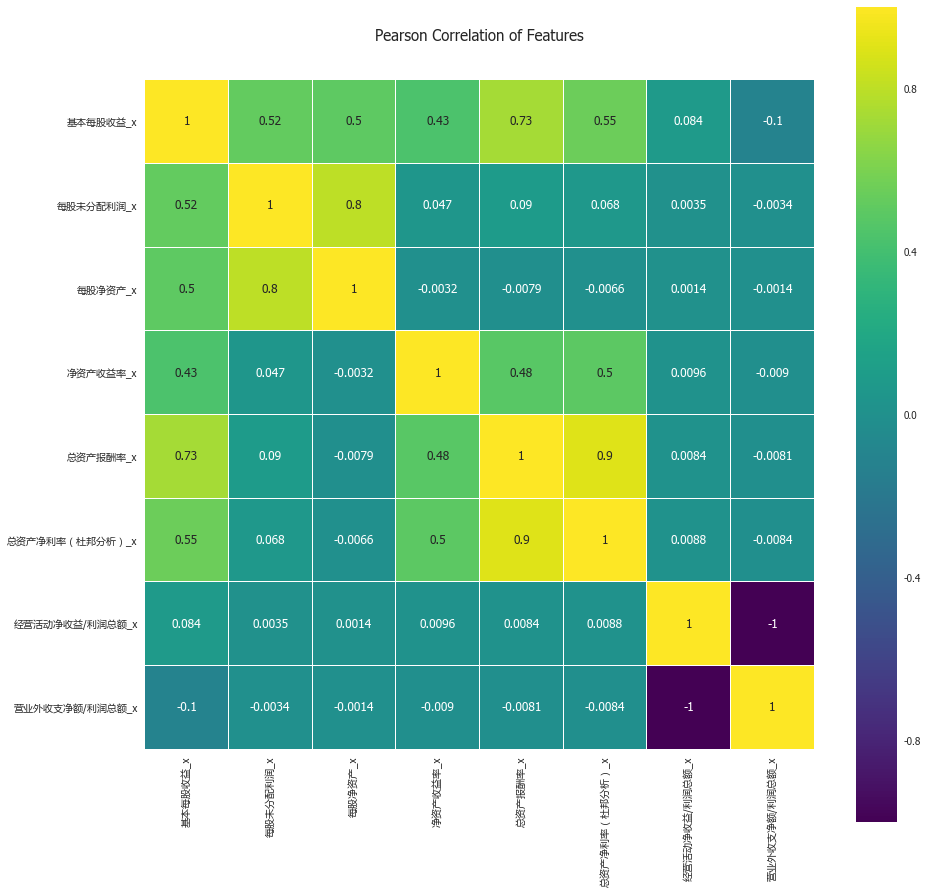

In [37]:
# 是否省份，地市会提高准确率？
b, label = encode_feature(b_quarter)
show_corr(b.iloc[:,:10])
run(b, label, 5000)
create_feature_map(b.columns)


In [ ]:
# 组合最近一期的年报/半年报/季报
# 用sklearn进行归一化（nan替换成none测试下）

In [ ]:
# 思路
1.一条记录中关联多个时间阶段的数据（1月，2月，3月...）
2.考虑评级机构不会每个月都发评级报告，考虑用前期评级报告关联后期财务数据，来丰富训练测试数据。（这个做法与目前的关联方式正好相反）
3.神经网络中考虑多条财务数据组成2维数组，非时间序列的特征采用冗余的方式
4.考虑标记财务指标特征（年报，半年报，季报）并用各不同类型的财务指标建模
5.模型融合（分别计算年报，半年报，季报的分类概率，将计算结果的分类概率作为数据输入，来计算分类输出）

In [ ]:
sns.factorplot(y='公司类型', data=b_year[b_year['公司类型']!='其他公司'], kind='count', hue='信用评级', size=8)
sns.factorplot(y='公司类型', data=b_year[b_year['公司类型']=='其他公司'], kind='count', hue='信用评级', size=8, aspect=2)
sns.factorplot(y='国籍', data=company_df[company_df['国籍']!='中国'], kind='count')
sns.factorplot(y='公司类型',data=company_df,kind="count", size=6, aspect=1)

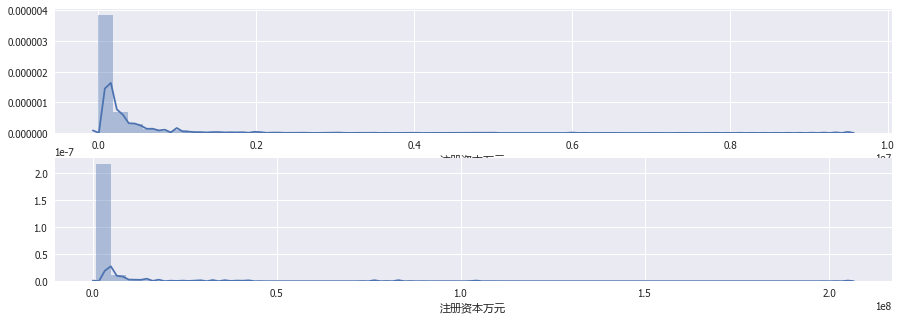

In [76]:
# 注册资本小于1000亿分布
plt.figure(figsize=(15.0, 5.0))
plt.subplot(211)
sns.distplot(company_df[company_df['注册资本万元'] < 10000000 ]['注册资本万元'])
plt.subplot(212)
sns.distplot(company_df[company_df['注册资本万元'] > 800000 ]['注册资本万元'])

In [ ]:
# MinMaxScaler
scale = pp.MinMaxScaler()
plt.figure(figsize=(15.0, 5.0))
plt.subplot(211)
x = company_df[company_df['注册资本万元'] < 5000000 ]['注册资本万元'].values.reshape(-1,1)
sns.distplot(scale.fit_transform(x), bins=100)
plt.subplot(212)
x = company_df[company_df['注册资本万元'] > 5000000 ]['注册资本万元'].values.reshape(-1,1)
sns.distplot(scale.fit_transform(x), bins=100)

In [ ]:
# 正则化Normalization
plt.figure(figsize=(15.0, 5.0))
plt.subplot(211)
x = company_df[company_df['注册资本万元'] < 5000000]['注册资本万元'].values.reshape(1,-1)
scale = pp.Normalizer().fit(x)
sns.distplot(scale.transform(x), bins=100)
plt.subplot(212)
x = company_df[company_df['注册资本万元'] > 5000000]['注册资本万元'].values.reshape(1,-1)
scale = pp.Normalizer().fit(x)
sns.distplot(scale.transform(x), bins=100)

In [ ]:
# sns.boxplot(company_df['注册资本万元'])
plt.figure(figsize=(15,10))
plt.subplot(211)
sns.boxplot(x="公司类别", y="注册资本万元", data=company_df[company_df['注册资本万元']<1000000])
plt.subplot(212)
sns.boxplot(x="公司类别", y="注册资本万元", data=company_df[company_df['注册资本万元']>1000000])
plt.figure(2)
plt.figure(figsize=(15,10))
sns.violinplot(x="公司类别", y="注册资本万元", data=company_df)

In [ ]:
level_df.columns

In [ ]:
sns.factorplot(y='信用评级', data=level_df, kind='count', size=7)
sns.factorplot(y='评级变动方向', data=level_df, kind='count', hue='评级类型')


In [ ]:
sns.jointplot(x='资产负债率',y='产权比率',data=bond_df, size=10)

In [ ]:
sns.pairplot(bond_df,hue="报告期")   #hue 选择分类列  

In [ ]:
# 查看各特征相关性
colormap = plt.cm.viridis
plt.figure(figsize=(15,15))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(bond_df.iloc[:, 3:].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [ ]:
# 数据关联
print(company_df.columns)
print(level_df.columns)

In [ ]:
company = pd.merge(company_df, level_df, how='inner', left_on='公司名称', right_on='公司中文名称')
company.columns
c = company.drop(['公司中文简介', '信用评级说明', '法人代表', '总经理', '董事会秘书', '主页', '电子邮箱', '经营范围',
                  '对象ID', '公司ID', '公司中文名称', '主要产品及业务', '办公地址'], axis=1)
c[['公司类别','评级类型','评级机构代码']] = c[['公司类别','评级类型','评级机构代码']].astype(str)
c['员工总数人'] = c[c['员工总数人'].notnull()]['员工总数人'].astype(int)

In [ ]:
c.describe()
c.columns

In [ ]:
bond = pd.merge(bond_df, c, how='inner', on='公司名称')

In [ ]:
# 查询报告期早于评级日期的记录
bond = bond[bond['报告期']<bond['评级日期']]
bond['sort_id'] = bond['评级日期'].groupby([bond['公司名称'], bond['报告期']]).rank(ascending=False)
bond = bond[bond['sort_id'] == 1]
bond.info()

In [ ]:
bond.describe()

In [ ]:
sns.FacetGrid(bond, hue='信用评级', size=8) \
.map(plt.scatter, '总资产报酬率', '同比增长率-营业利润(%)') \
.add_legend()

In [ ]:
bond.columns

In [ ]:
sns.pairplot(bond[['速动比率', '产权比率',
       '存货周转率',
       '信用评级']], hue='信用评级', diag_kind='kde')